# Pure MCTS Optimization

## Todo for v3.1

1. Optimize `get_valid_move` function. To do: make a valid move subset funtion. OK
2. Tree Reuse (X)
3. Change state to boolean X (May not effective)

## Problems to check

1. This version is not as good as 2.3.2 in terms of M(n). Check changes in get_ucb, and parallel logic.

## Todo for next version
1. 8 congruent state
2. MCGS (Trying now)
3. Search along priority function
4. Search action and update priority

In [1]:
import numpy as np
print(np.__version__)
np.random.seed(0)
import math
from itertools import combinations

import matplotlib.pyplot as plt

from tqdm.notebook import trange

import random

from numba import njit

import threading
from concurrent.futures import ThreadPoolExecutor, wait

import time

from pprint import pprint

2.1.3


## Define value function at first.

In [2]:
@njit(cache=True)
def value_fn_nb(x):
    return np.exp(x)

@njit(cache=True)
def get_value_nb(state, pts_upper_bound, value_f=value_fn_nb):
    total = np.sum(state)
    return value_f(total) / value_f(pts_upper_bound)

## Framework

In [3]:
# JIT-compiled function to check if three points are collinear
@njit(cache=True)
def _are_collinear(x1, y1, x2, y2, x3, y3):
    return (y1 - y2) * (x1 - x3) == (y1 - y3) * (x1 - x2)

# JIT-compiled function to determine valid moves on the board
@njit(cache=True)
def get_valid_moves_nb(state, row_count, column_count):
    max_pts = row_count * column_count
    coords = np.empty((max_pts, 2), np.int64)
    n_pts = 0

    # Collect coordinates of existing points
    for i in range(row_count):
        for j in range(column_count):
            if state[i, j] == 1:
                coords[n_pts, 0] = i
                coords[n_pts, 1] = j
                n_pts += 1

    mask = np.zeros(row_count * column_count, np.uint8)

    # Check each empty cell
    for i in range(row_count):
        for j in range(column_count):
            if state[i, j] != 0:
                continue
            valid = True
            # Check for collinearity with every pair of existing points
            for p in range(n_pts):
                for q in range(p + 1, n_pts):
                    i1, j1 = coords[p, 0], coords[p, 1]
                    i2, j2 = coords[q, 0], coords[q, 1]
                    if _are_collinear(j1, i1, j2, i2, j, i):
                        valid = False
                        break
                if not valid:
                    break
            if valid:
                mask[i * column_count + j] = 1
    return mask

@njit(cache=True)
def get_valid_moves_subset_nb(parent_state, parent_valid_moves, action_taken, row_count, column_count):
    """
    Given a parent state (2D boolean array) and its valid move mask (1D uint8 array),
    return a refined valid move mask for the child:
      1) Remove the action just taken.
      2) For each existing point in state, compute the line to the new point,
         then invalidate any intermediate grid points that lie exactly on that line.
      3) If slope is infinite, invalidate entire column; if slope is zero, invalidate entire row.
    Returns a flattened uint8 array: 1 = valid, 0 = invalid.
    """
    # Copy input mask and remove the taken action
    mask = parent_valid_moves.copy()
    mask[action_taken] = 0

    # Coordinates of the newly placed point
    new_r = action_taken // column_count
    new_c = action_taken % column_count

    # Iterate over all existing points
    for pr in range(row_count):
        for pc in range(column_count):
            if not parent_state[pr, pc]:
                continue
            # Skip the new point itself
            if pr == new_r and pc == new_c:
                continue

            dr = pr - new_r
            dc = pc - new_c

            # Infinite slope (vertical line): invalidate entire column
            if dc == 0:
                for rr in range(row_count):
                    idx = rr * column_count + new_c
                    mask[idx] = 0
                continue

            # Zero slope (horizontal line): invalidate entire row
            if dr == 0:
                row_index = pr
                base = row_index * column_count
                for cc in range(column_count):
                    mask[base + cc] = 0
                continue

            # General (non-vertical, non-horizontal) case: remove every point on the infinite line
            # through (new_r,new_c) and (pr,pc), including both the segment and its extensions.
            for cc in range(column_count):
                # compute how far horizontally from the new point
                num = (cc - new_c) * dr
                # only those aligning to integer row are collinear
                if num % dc != 0:
                    continue
                rr = new_r + num // dc
                # skip anything outside the grid
                if rr < 0 or rr >= row_count:
                    continue
                idx = rr * column_count + cc
                mask[idx] = 0

    return mask

# JIT-compiled function to count collinear triples on the board
@njit(cache=True)
def check_collinear_nb(state, row_count, column_count):
    max_pts = row_count * column_count
    coords = np.empty((max_pts, 2), np.int64)
    n_pts = 0

    # Collect all placed point coordinates
    for i in range(row_count):
        for j in range(column_count):
            if state[i, j] == 1:
                coords[n_pts, 0] = i
                coords[n_pts, 1] = j
                n_pts += 1

    triples = 0
    # Count all collinear triplets
    for a in range(n_pts):
        for b in range(a + 1, n_pts):
            for c in range(b + 1, n_pts):
                i1, j1 = coords[a, 0], coords[a, 1]
                i2, j2 = coords[b, 0], coords[b, 1]
                i3, j3 = coords[c, 0], coords[c, 1]
                if _are_collinear(j1, i1, j2, i2, j3, i3):
                    triples += 1
    return triples


# JIT-compiled function to perform a full random rollout until terminal
# @njit(cache=True)
def simulate_nb(state, row_count, column_count, pts_upper_bound):
    """
    Perform random rollout until no valid moves remain.
    Return normalized value using a custom value function.
    Uses get_valid_moves_subset_nb for incremental validity updates.
    """
    max_size = row_count * column_count
    # Initial valid moves mask
    valid_moves = get_valid_moves_nb(state, row_count, column_count)
    total_valid = np.sum(valid_moves)

    while total_valid > 0:
        # Build list of valid actions



        acts = np.empty(total_valid, np.int64)
        k = 0
        for idx in range(max_size):
            if valid_moves[idx]:
                acts[k] = idx
                k += 1
        # Randomly select one valid action and place the point
        pick = acts[np.random.randint(0, total_valid)]

        # Incrementally update valid_moves using subset-based filtering
        valid_moves = get_valid_moves_subset_nb(
            state,
            valid_moves,
            pick,
            row_count,
            column_count
        )

        r = pick // column_count
        c = pick % column_count
        state[r, c] = 1  # mark the new point

        total_valid = np.sum(valid_moves)

    # Compute and return the final value
    return get_value_nb(state, pts_upper_bound)


class N3il:
    def __init__(self, grid_size, args):
        self.row_count, self.column_count = grid_size
        self.pts_upper_bound = np.min(grid_size) * 2
        self.action_size = self.row_count * self.column_count
        self.args = args

    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count), np.uint8)

    def get_next_state(self, state, action):
        row = action // self.column_count
        col = action % self.column_count
        state[row, col] = 1
        return state

    def get_valid_moves(self, state):
        # Call numba-accelerated function
        return get_valid_moves_nb(state, self.row_count, self.column_count)

    def get_valid_moves_subset(self, parent_state, parent_valid_moves, action_taken):
        return get_valid_moves_subset_nb(parent_state, parent_valid_moves, action_taken, self.row_count, self.column_count)

    def check_collinear(self, state, action=None):
        if action is not None:
            temp_state = state.copy()
            row = action // self.column_count
            col = action % self.column_count
            temp_state[row, col] = 1
        else:
            temp_state = state

        # Call numba-accelerated function
        return check_collinear_nb(temp_state, self.row_count, self.column_count)

    def get_value_and_terminated(self, state, valid_moves):
        """
        Return the normalized value and terminal status of the current state.
        Delegates value calculation to get_value_nb().
        """
        if np.sum(valid_moves) > 0:
            return 0.0, False

        value = get_value_nb(state, self.pts_upper_bound)
        return value, True
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == 0, state == 1)
        ).astype(np.float32)
        
        return encoded_state

    def display_state(self, state, action_prob=None):
        """
        Display the current grid configuration using matplotlib.
        Points are drawn where the state equals 1.
        The origin (0, 0) is located at the bottom-left.
        If action_prob is provided (1D array), it is reshaped and overlaid as a heatmap.
        """
        plt.figure(figsize=(10, 10))
        ax = plt.gca()

        if action_prob is not None:
            assert action_prob.shape[0] == self.row_count * self.column_count, \
                f"Expected length {self.row_count * self.column_count}, got {len(action_prob)}"
            action_prob_2d = action_prob.reshape((self.row_count, self.column_count))
            flipped_probs = np.flipud(action_prob_2d)

            im = ax.imshow(
                flipped_probs,
                cmap='Reds',
                alpha=0.6,
                extent=[-0.5, self.column_count - 0.5, -0.5, self.row_count - 0.5],
                origin='lower',
                vmin=0, vmax=np.max(action_prob) if np.max(action_prob) > 0 else 1e-5
            )
            plt.colorbar(im, label="Action Probability", shrink=0.8)

            # Find maximum probability
            max_val = np.max(action_prob_2d)
            max_positions = np.argwhere(action_prob_2d == max_val)

            # Add text annotations for probabilities
            for i in range(self.row_count):
                for j in range(self.column_count):
                    val = action_prob_2d[i, j]
                    display_y = self.row_count - 1 - i  # Flip vertically
                    is_max = any((i == mp[0] and j == mp[1]) for mp in max_positions)
                    ax.text(
                        j, display_y, f"{val:.3f}",
                        ha="center", va="center",
                        color="gold" if is_max else ("black" if val < 0.5 * max_val else "white"),
                        weight='bold' if is_max else 'normal',
                        fontsize=6
                    )

        # Plot placed points
        y_coords, x_coords = np.nonzero(state)
        flipped_y = self.row_count - 1 - y_coords
        plt.scatter(x_coords, flipped_y, s=20, c='blue', label='Placed Points')

        plt.grid(True)
        plt.xticks(range(self.column_count))
        plt.yticks(range(self.row_count))
        plt.xlim(-0.5, self.column_count - 0.5)
        plt.ylim(-0.5, self.row_count - 0.5)
        ax.set_aspect('equal')
        plt.title("No-Three-In-Line Grid with Action Probabilities" if action_prob is not None else "No-Three-In-Line Grid")
        plt.show()

'''
Adapt from
foersterrobert/AlphaZeroFromScratch
'''

class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken

        self.children = []
        self.visit_count = 0
        self.value_sum = 0
        self.lock = threading.Lock()
        self._vl = args.get('virtual_loss', 1.0)

        if parent is None:
            self.valid_moves = game.get_valid_moves(state)
        else:
            self.valid_moves = game.get_valid_moves_subset(
                parent.state, parent.valid_moves, self.action_taken)

        self.is_full = False
        self._cached_ucb = None     # Cached UCB value
        self._ucb_dirty = True      # Indicates whether the cached UCB is stale

    def apply_virtual_loss(self):
        with self.lock:
            self.value_sum -= self._vl
            self.visit_count += 1
            self._ucb_dirty = True  # Mark UCB as outdated

    def revert_virtual_loss(self):
        with self.lock:
            self.value_sum += self._vl
            self._ucb_dirty = True  # Mark UCB as outdated

    def is_fully_expanded(self):
        return self.is_full and len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf
        log_N = math.log(self.visit_count)

        for child in self.children:
            ucb = self.get_ucb(child, log_N)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child, log_N=None):
        if log_N is None:
            log_N = math.log(self.visit_count)

        with child.lock:
            if not child._ucb_dirty and child._cached_ucb is not None:
                return child._cached_ucb

            q_value = child.value_sum / child.visit_count
            ucb = q_value + self.args['C'] * math.sqrt(log_N / child.visit_count)
            child._cached_ucb = ucb
            child._ucb_dirty = False
            return ucb

    def expand(self):
        valid_indices = np.where(self.valid_moves == 1)[0]
        action = np.random.choice(valid_indices)
        self.valid_moves[action] = 0

        if np.sum(self.valid_moves) == 0:
            self.is_full = True

        child_state = self.state.copy()
        child_state = self.game.get_next_state(child_state, action)

        child = Node(self.game, self.args, child_state, self, action)
        self.children.append(child)
        return child

    def simulate(self):
        tmp = self.state.copy()
        return simulate_nb(tmp,
                           self.game.row_count,
                           self.game.column_count,
                           self.game.pts_upper_bound)

    def backpropagate(self, value):
        with self.lock:
            self.value_sum += value
            self._ucb_dirty = True  # Mark UCB as outdated
        self.visit_count += 1
        if self.parent is not None:
            self.parent.backpropagate(value)

class MCTS:
    def __init__(self, game, args={
        'num_searches': 1000,
        'C': 1.4
    }):
        self.game = game
        self.args = args

    def search(self, state):
        # define root
        root = Node(self.game, self.args, state)

        if self.args['process_bar'] == True:
            search_iterator = trange(self.args['num_searches'])
        else:
            search_iterator = range(self.args['num_searches'])

        for search in search_iterator:
            node = root

            # selection
            while node.is_fully_expanded():
                node = node.select()

            if node.action_taken is not None:
                value, is_terminal = self.game.get_value_and_terminated(node.state, node.valid_moves)
                # has_collinear = self.game.check_collinear(node.state, node.action_taken)
                # value, _ = self.game.get_value_and_terminated(node.state)

                if not is_terminal:
                    node = node.expand()
                    value = node.simulate()
            else:
                node = node.expand()
                value = node.simulate()

            node.backpropagate(value)

        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs
            
            # expansion
            # simulation
            # backpropagation

        # return visit_counts

class ParallelMCTS(MCTS):
    def __init__(self, game, args):
        super().__init__(game, args)
        self.num_workers   = args.get('num_workers', 4)
        self.virtual_loss  = args.get('virtual_loss', 1.0)
        self.args = args

    # --- single simulation --------------------------------------------------
    def _search_once(self, root):
        path = []
        node = root

        # 1. SELECTION
        while node.is_fully_expanded():
            path.append(node)
            node.apply_virtual_loss()         # <‑‑ reserve
            node = node.select()

        # 2. EXPANSION / SIMULATION
        if node.action_taken is None:
            node = node.expand()
        path.append(node)
        node.apply_virtual_loss()             # reserve leaf
        value = node.simulate() if not self.game.get_value_and_terminated(
            node.state, node.valid_moves
        )[1] else self.game.get_value_and_terminated(
            node.state, node.valid_moves
        )[0]

        # 3. UNDO VIRTUAL LOSS + BACKPROP
        for n in path:
            n.revert_virtual_loss()
        node.backpropagate(value)
    # ------------------------------------------------------------------------

    # --- parallel driver ----------------------------------------------------
    def search(self, state):
        root = Node(self.game, self.args, state)

        sims_per_worker = self.args['num_searches'] // self.num_workers
        remainder       = self.args['num_searches'] %  self.num_workers

        def worker(n_sims):
            if self.args['process_bar'] == True:
                for _ in trange(n_sims):
                    self._search_once(root)
            else:
                for _ in range(n_sims):
                    self._search_once(root)

        with ThreadPoolExecutor(max_workers=self.num_workers) as pool:
            futures = [pool.submit(worker, sims_per_worker)
                       for _ in range(self.num_workers)]
            if remainder:                     # handle leftovers
                futures.append(pool.submit(worker, remainder))
            wait(futures)

        # convert visit counts → prob. vector
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs


def select_outermost_with_tiebreaker(mcts_probs, n):
    """
    Select an action from the outermost positions among those with the highest MCTS probability.
    If multiple actions have the same max probability and distance to edge, break ties randomly.
    """
    # Reshape the 1D probability array to 2D grid
    mcts_probs_2d = mcts_probs.reshape((n, n))
    max_val = np.max(mcts_probs_2d)

    # Find all positions with maximum probability
    max_indices = np.argwhere(mcts_probs_2d == max_val)

    # Define distance to nearest board edge
    def edge_distance(i, j):
        return min(i, n - 1 - i, j, n - 1 - j)

    # Compute edge distance for each candidate
    distances = [edge_distance(i, j) for i, j in max_indices]
    min_dist = min(distances)

    # Select all actions with minimum edge distance
    outermost_positions = [pos for pos, dist in zip(max_indices, distances) if dist == min_dist]

    # Break ties randomly among outermost positions
    chosen_pos = outermost_positions[np.random.choice(len(outermost_positions))]
    action = chosen_pos[0] * n + chosen_pos[1]
    return action

def evaluate(args):
    start = time.time()
    n = args['n']
    n3il = N3il(grid_size=(n, n), args=args)

    mcts_cls = ParallelMCTS if args.get('num_workers', 1) > 1 else MCTS
    mcts = mcts_cls(n3il, args=args)

    state = n3il.get_initial_state()
    num_of_points = 0

    while True:
        print("---------------------------")
        print(f"Number of points: {num_of_points}")
        print(state)

        valid_moves = n3il.get_valid_moves(state)
        value, is_terminal = n3il.get_value_and_terminated(state, valid_moves)

        if is_terminal:
            print("*******************************************************************")
            print(f"Trial Terminated with {num_of_points} points. Final valid configuration:")
            print(state)
            n3il.display_state(state, mcts_probs)
            end = time.time()
            print(f"Time: {end - start:.6f} sec")
            break

        # Get MCTS probabilities
        mcts_probs = mcts.search(state)

        # Use outermost-priority selector to pick action
        action = select_outermost_with_tiebreaker(mcts_probs, n)

        # Display MCTS probabilities and board
        if args['display_state'] == True:
            n3il.display_state(state, mcts_probs)

        # Apply action
        num_of_points += 1
        state = n3il.get_next_state(state, action)

## N = 10

---------------------------
Number of points: 0
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

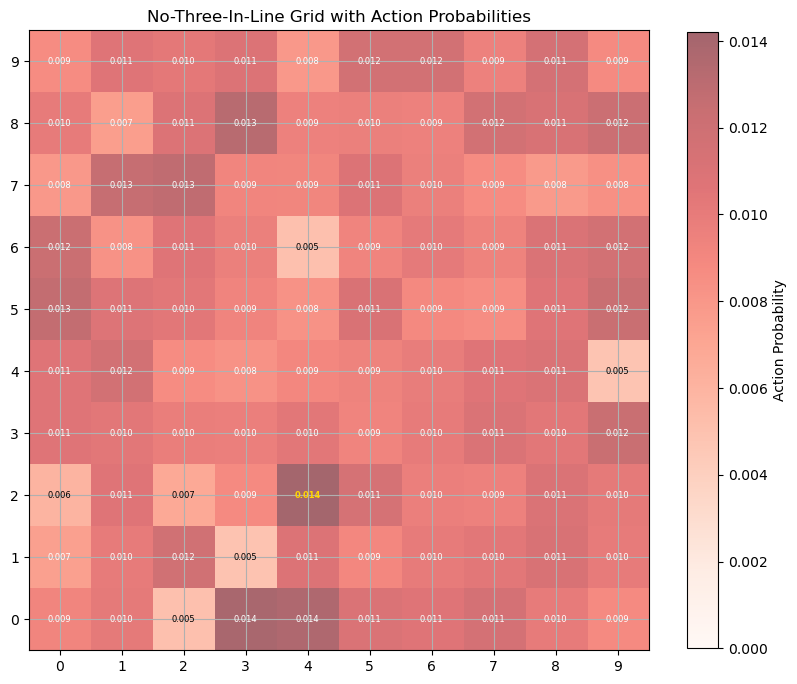

---------------------------
Number of points: 1
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

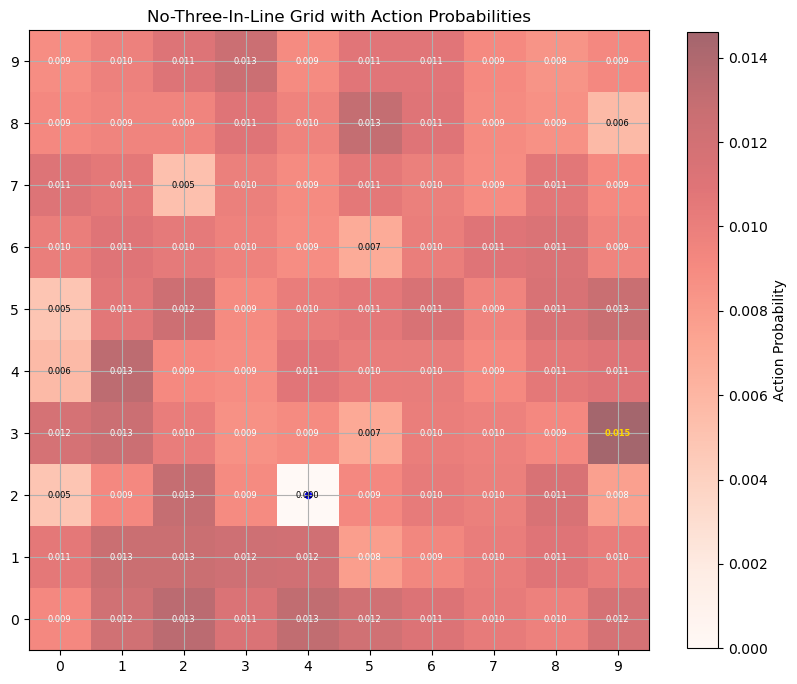

---------------------------
Number of points: 2
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

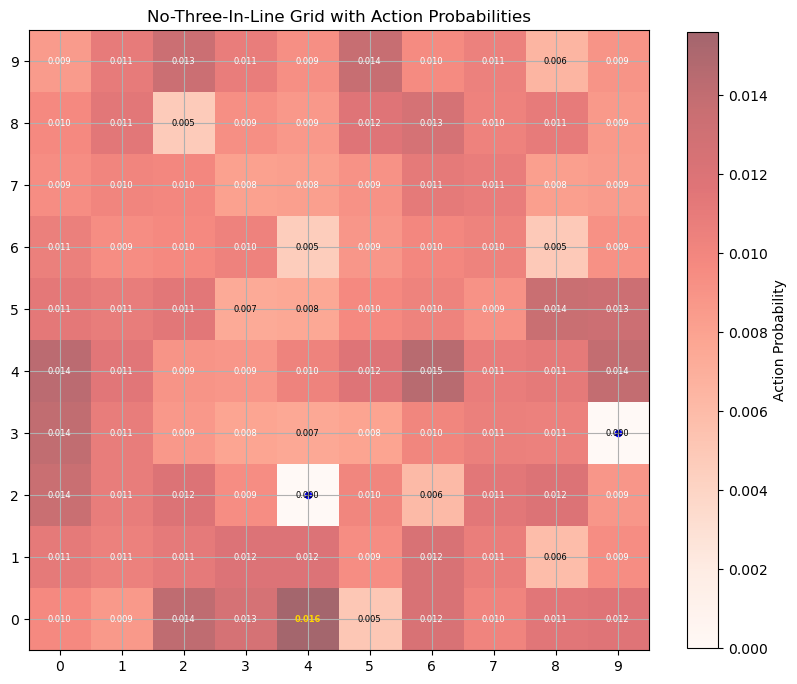

---------------------------
Number of points: 3
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

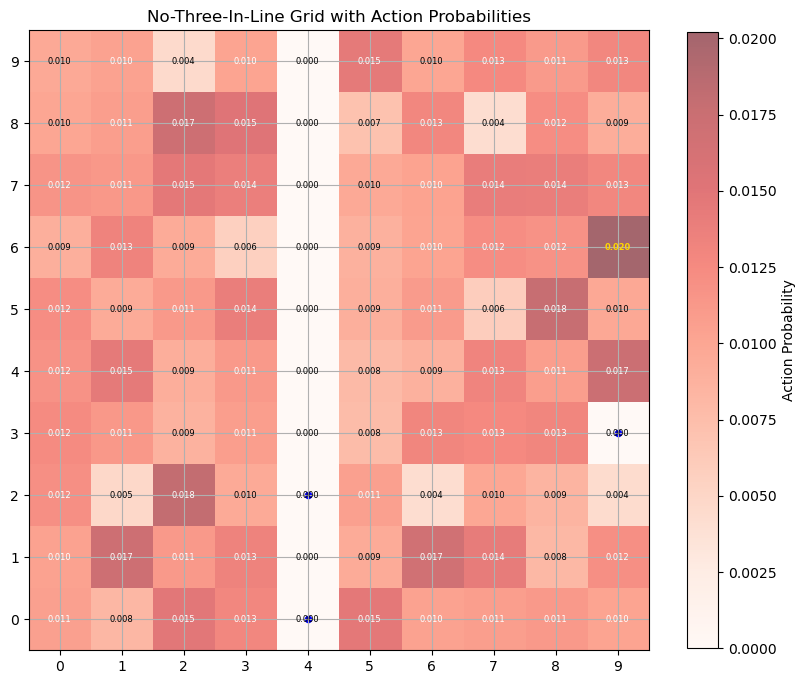

---------------------------
Number of points: 4
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

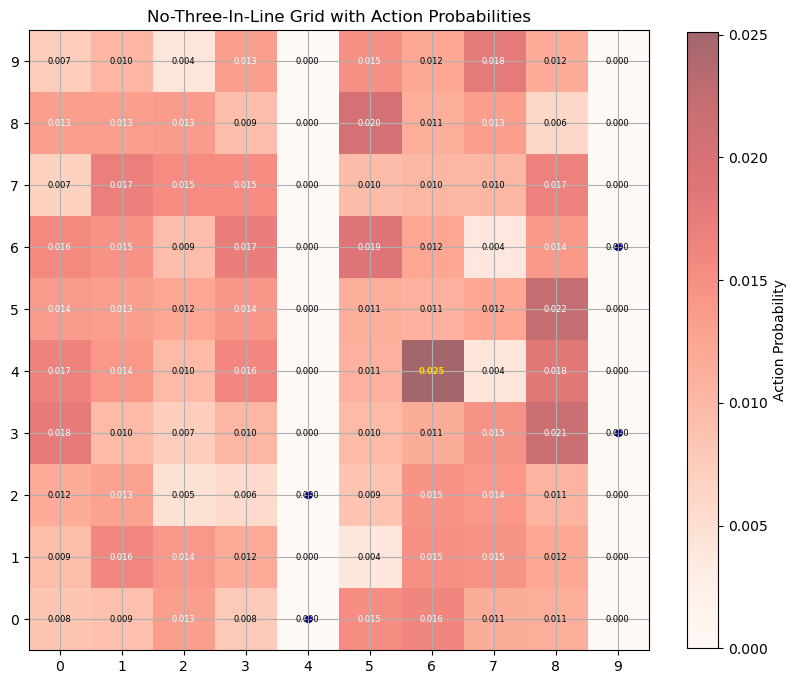

---------------------------
Number of points: 5
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

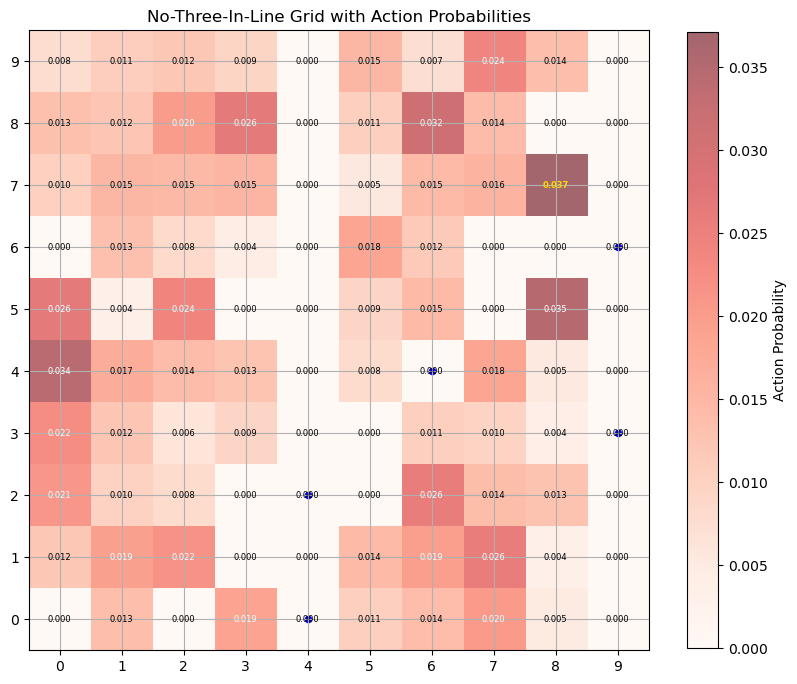

---------------------------
Number of points: 6
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

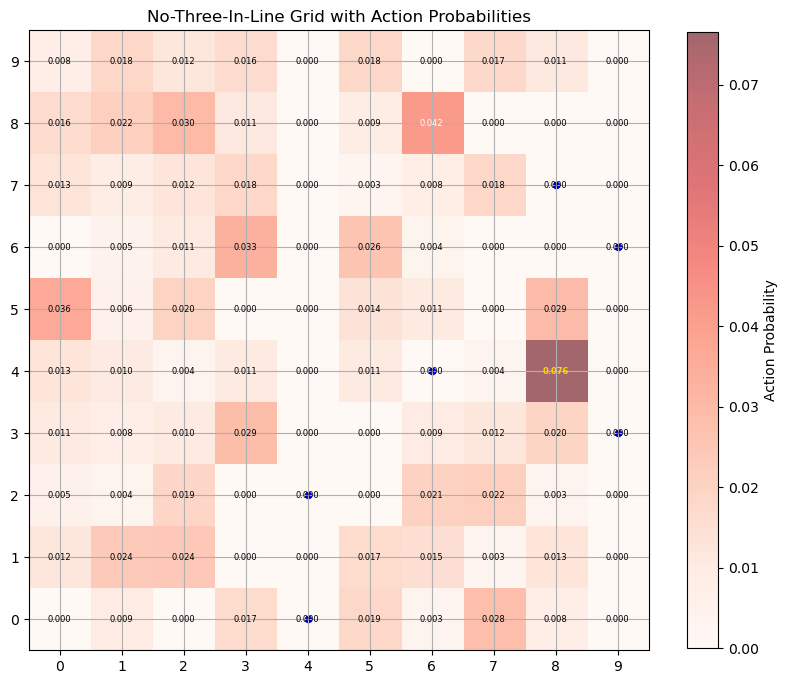

---------------------------
Number of points: 7
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

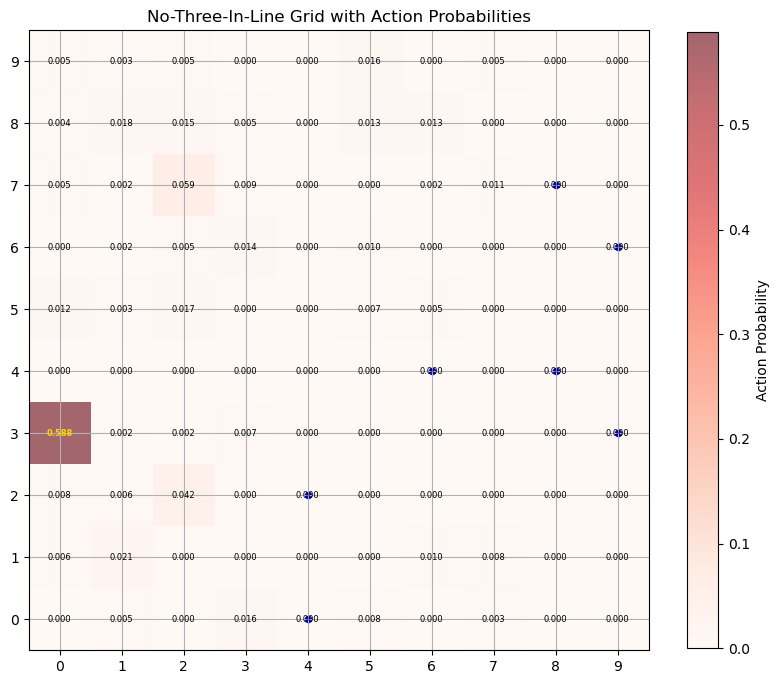

---------------------------
Number of points: 8
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

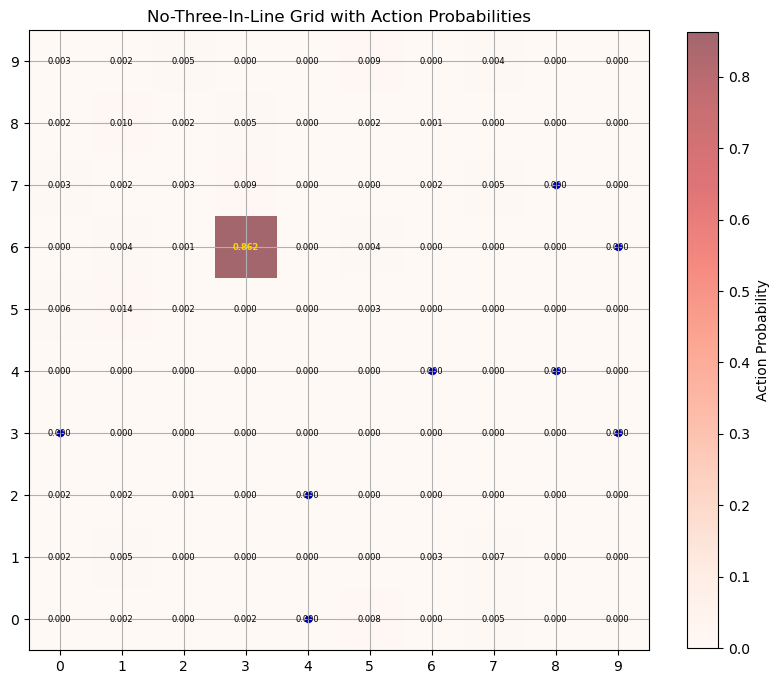

---------------------------
Number of points: 9
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

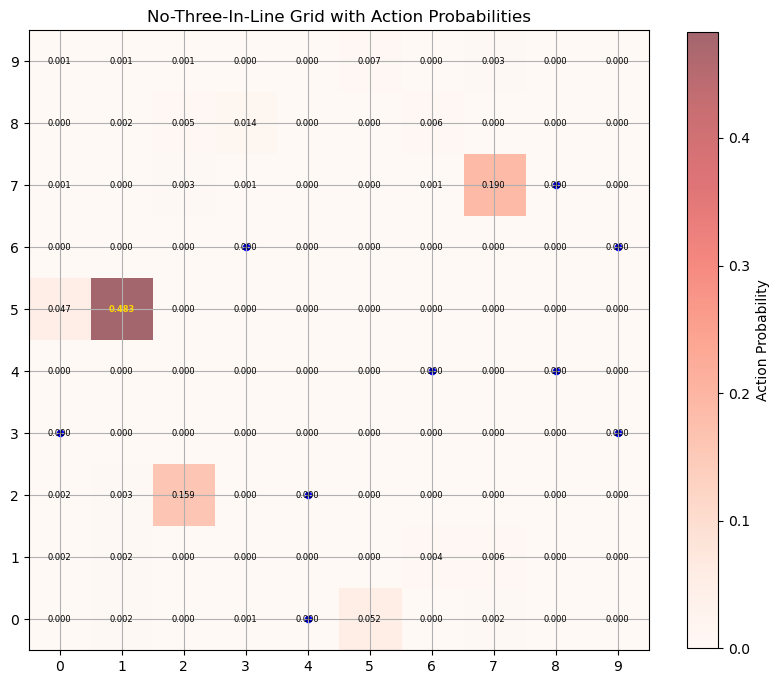

---------------------------
Number of points: 10
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

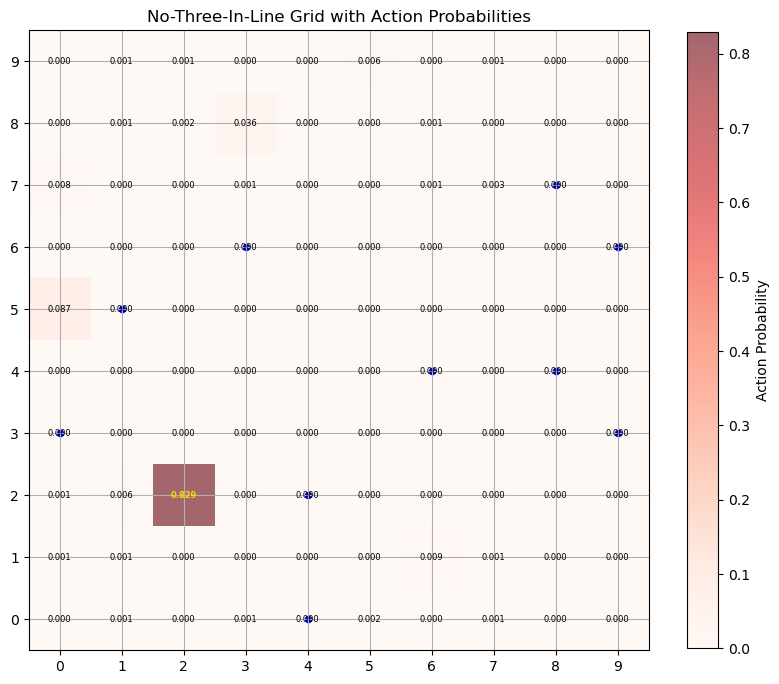

---------------------------
Number of points: 11
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

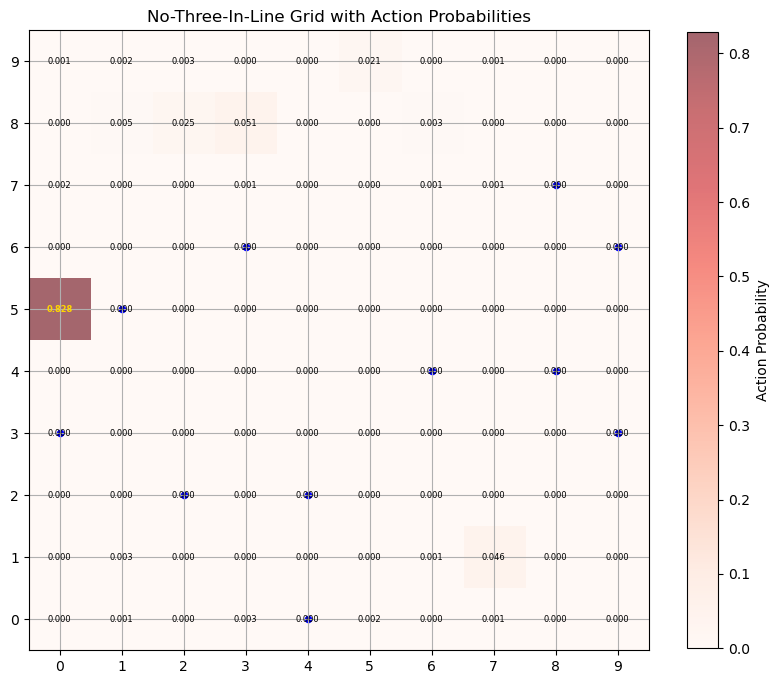

---------------------------
Number of points: 12
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

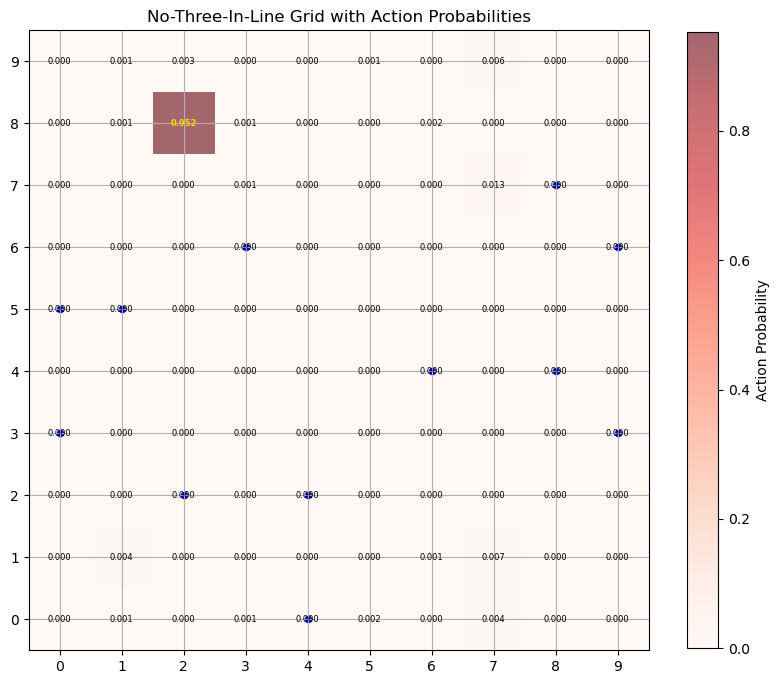

---------------------------
Number of points: 13
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

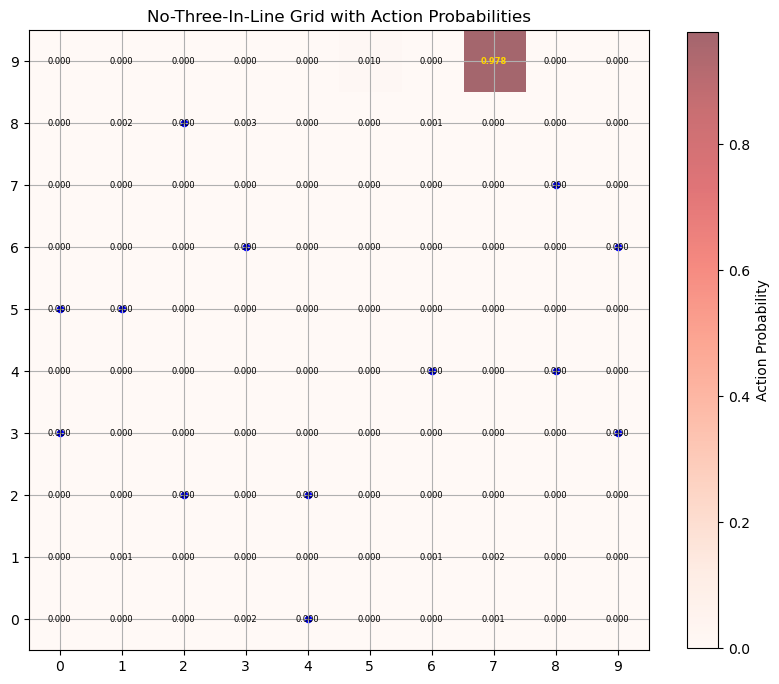

---------------------------
Number of points: 14
[[0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

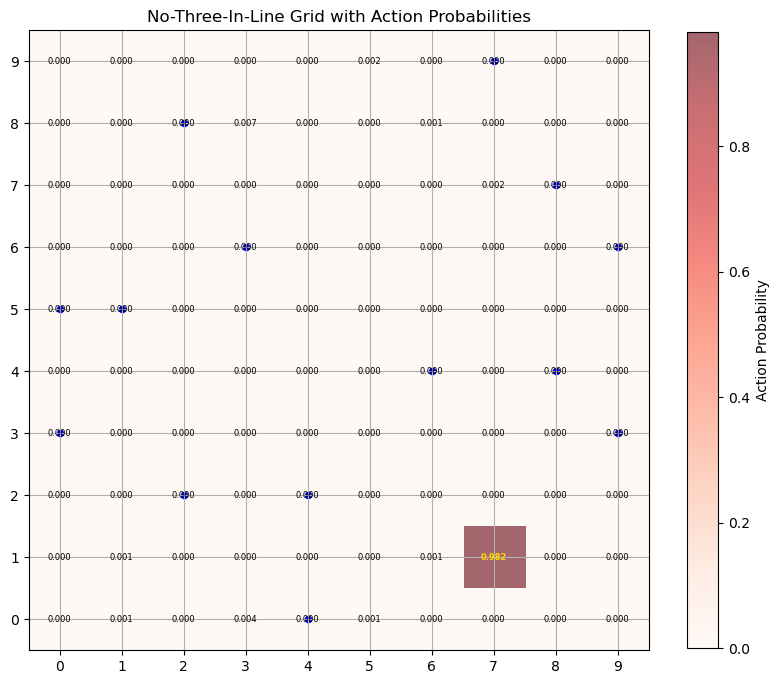

---------------------------
Number of points: 15
[[0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

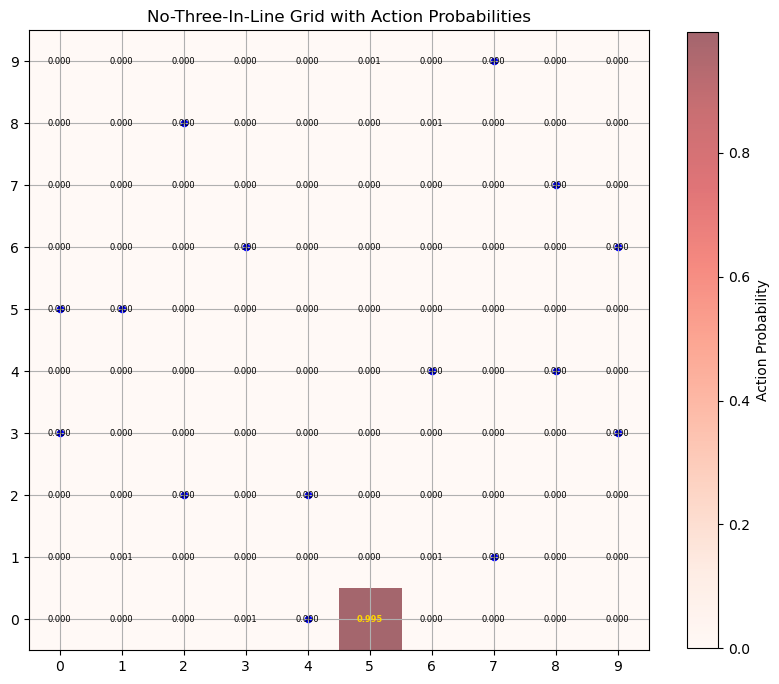

---------------------------
Number of points: 16
[[0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

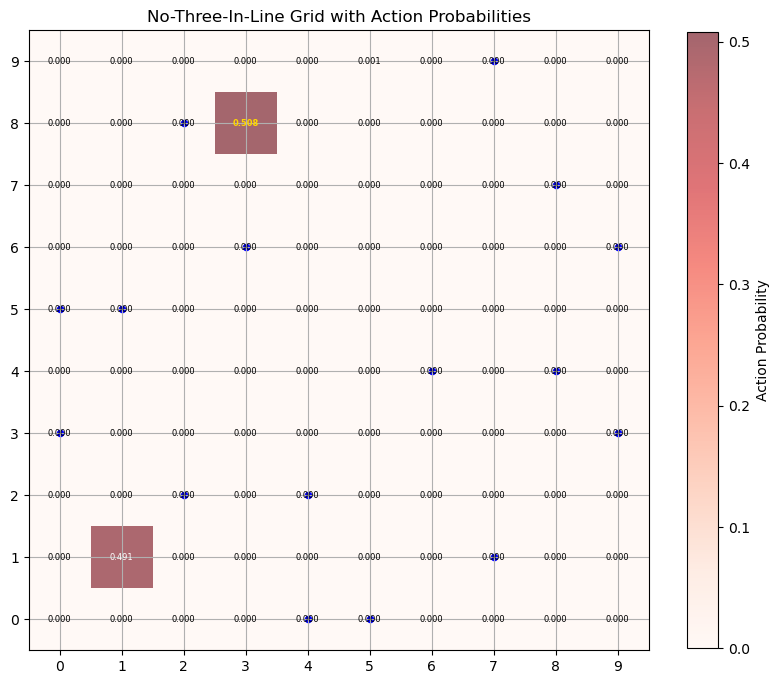

---------------------------
Number of points: 17
[[0 0 0 0 0 0 0 1 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

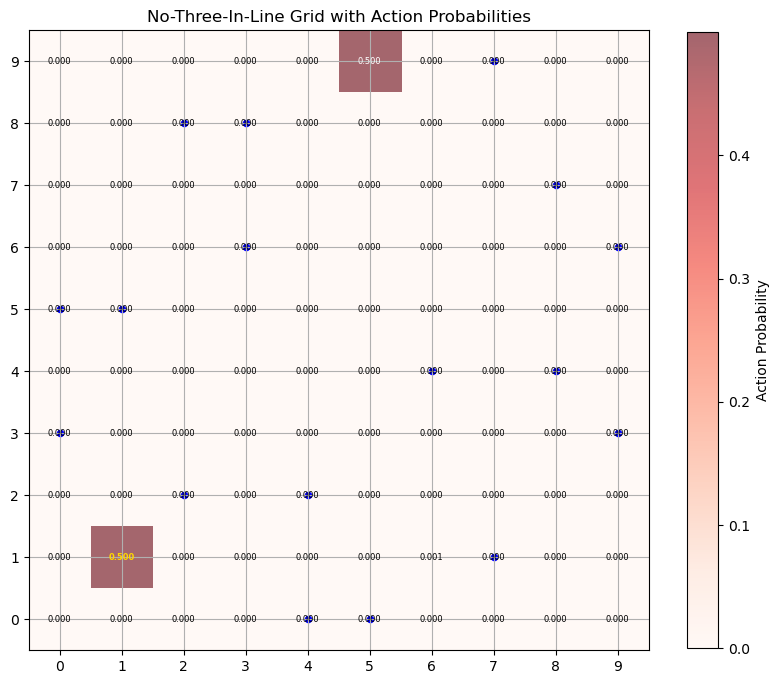

---------------------------
Number of points: 18
[[0 0 0 0 0 0 0 1 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

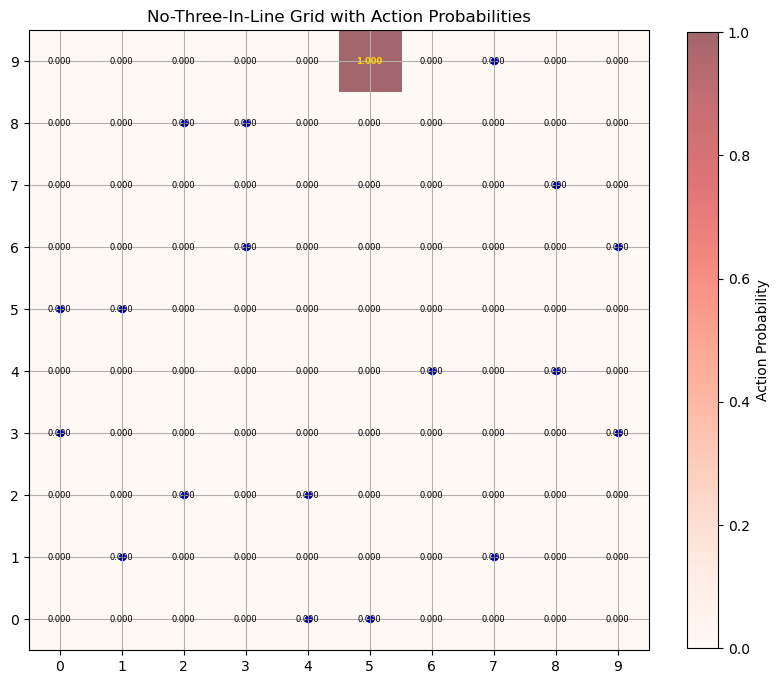

---------------------------
Number of points: 19
[[0 0 0 0 0 1 0 1 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0 0 0]]
*******************************************************************
Trial Terminated with 19 points. Final valid configuration:
[[0 0 0 0 0 1 0 1 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0 0 0]]


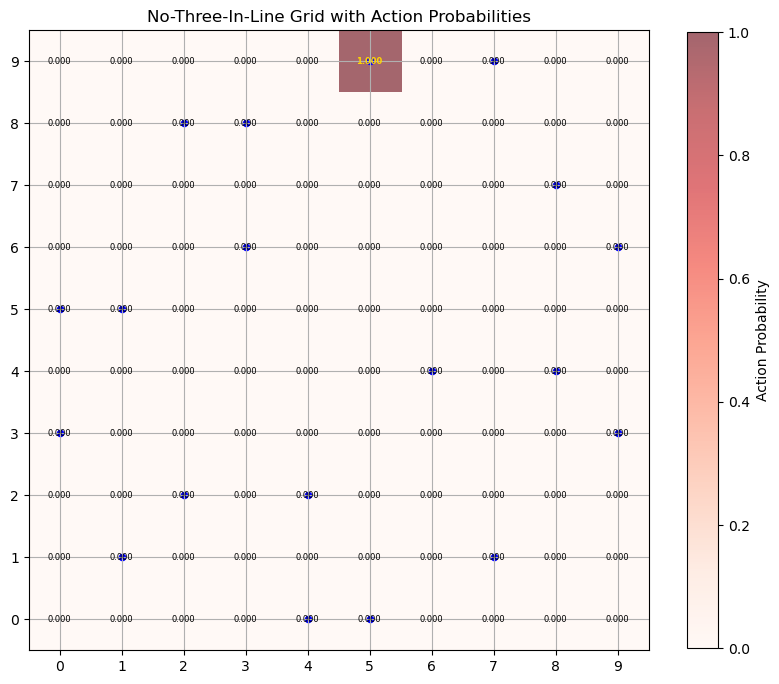

Time: 55.608254 sec


In [4]:
"""
import cProfile
import pstats

cProfile.run('main()', 'profile_output.prof')

p = pstats.Stats('profile_output.prof')
p.sort_stats('cumtime').print_stats(50) 
"""
np.random.seed(0)

args = {
        'n': 10,
        'C': 1/np.exp(2),
        'num_searches': 10_000,
        'num_workers'  : 1,      # >1 ⇒ parallel
        'virtual_loss' : 1.0,     # magnitude to subtract at reservation
        'process_bar' : True,
        'display_state' : True
    }

evaluate(args)

## N = 10 (1)

---------------------------
Number of points: 0
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

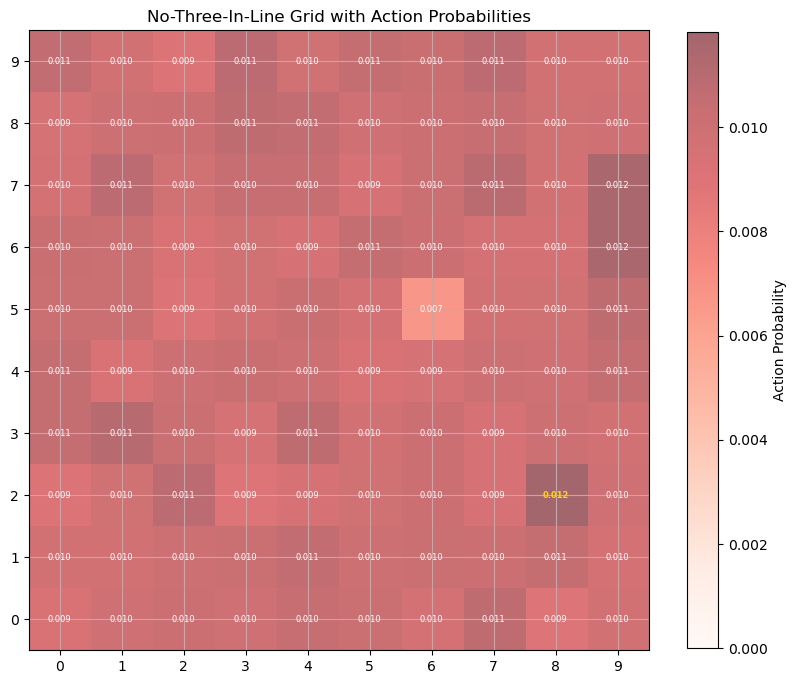

---------------------------
Number of points: 1
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

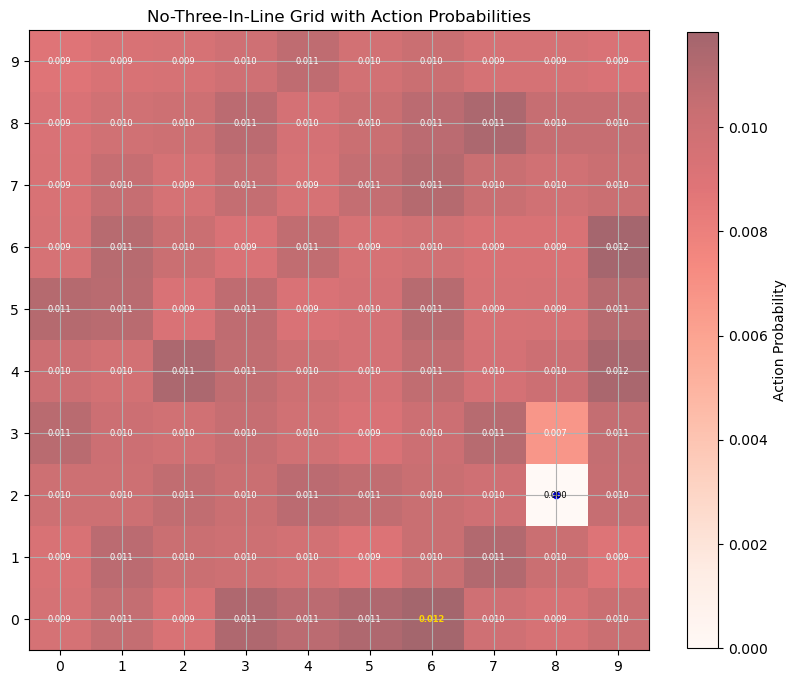

---------------------------
Number of points: 2
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

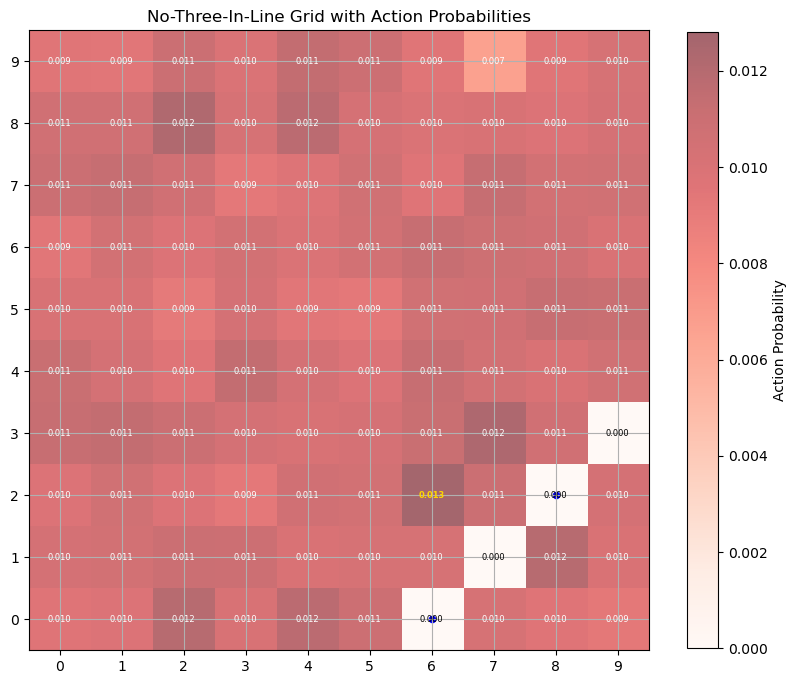

---------------------------
Number of points: 3
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

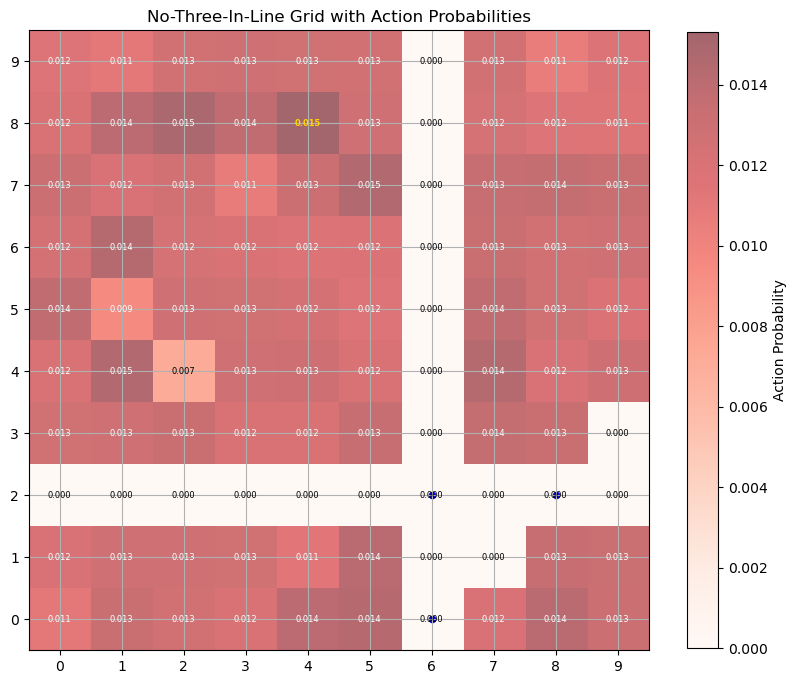

---------------------------
Number of points: 4
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

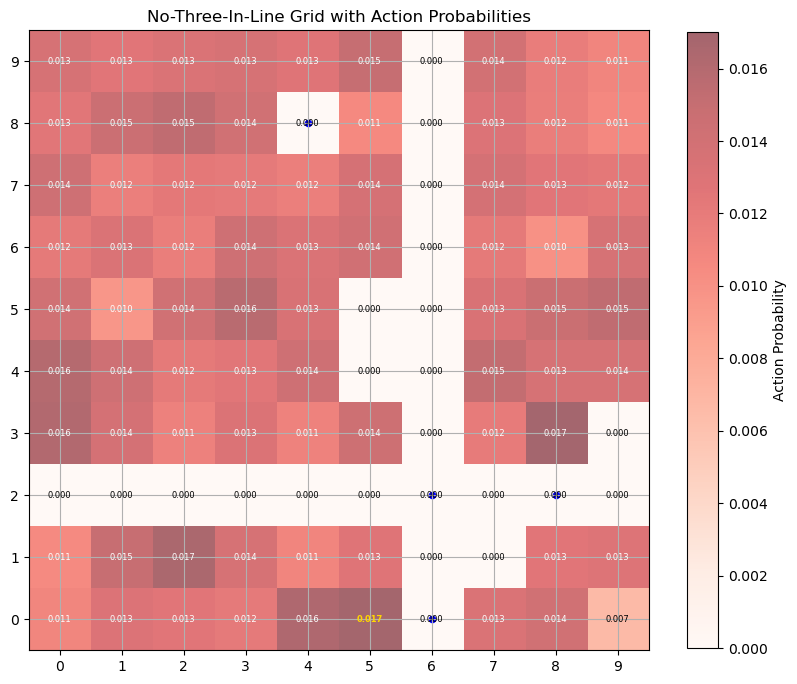

---------------------------
Number of points: 5
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

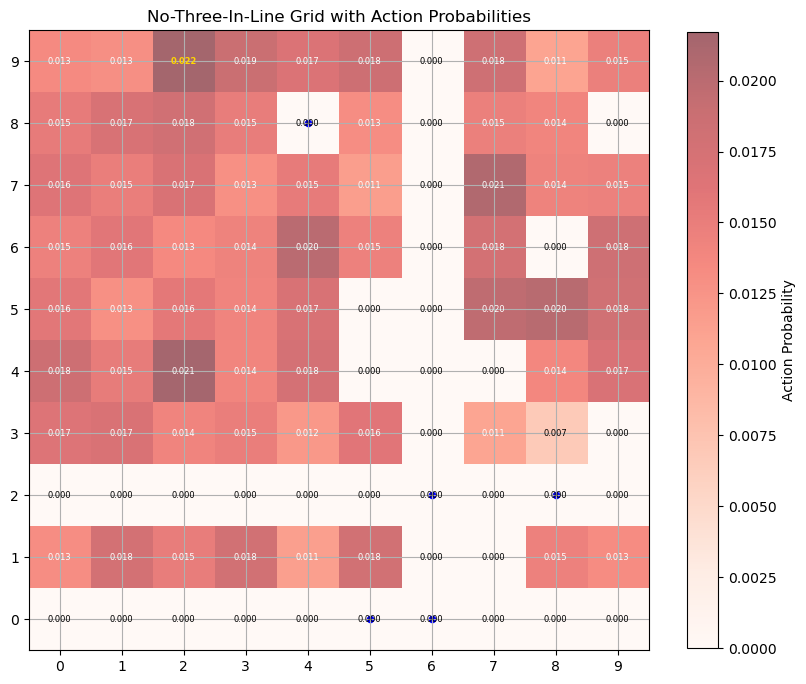

---------------------------
Number of points: 6
[[0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

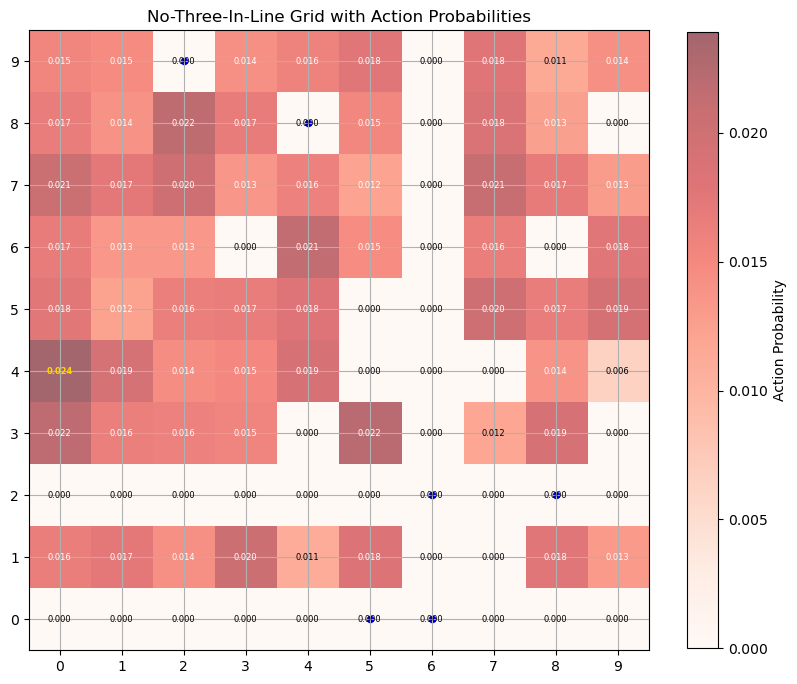

---------------------------
Number of points: 7
[[0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

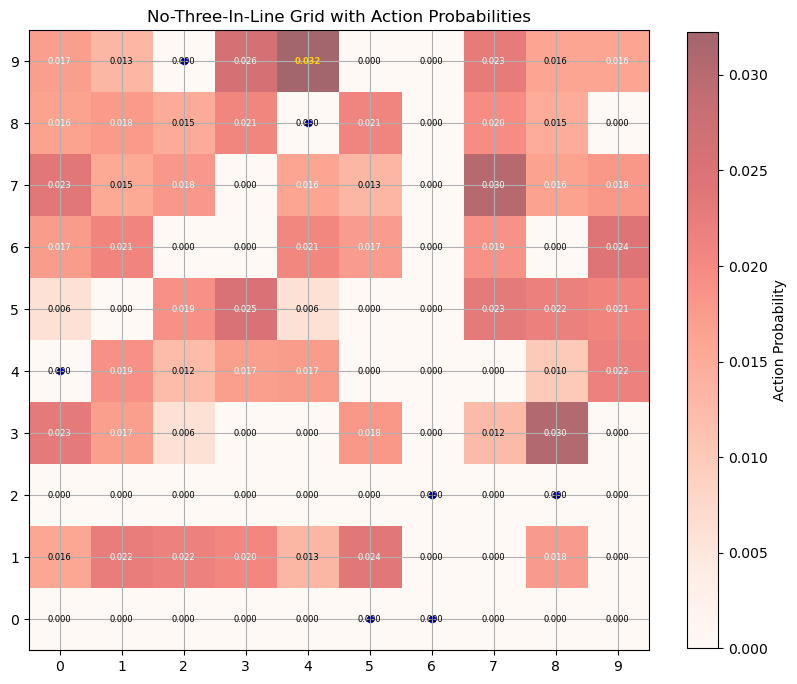

---------------------------
Number of points: 8
[[0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

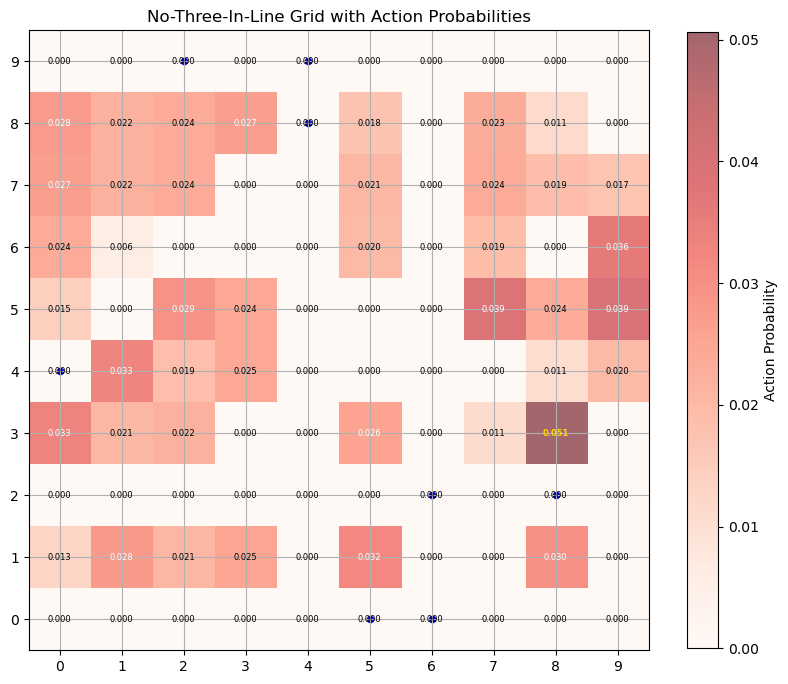

---------------------------
Number of points: 9
[[0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

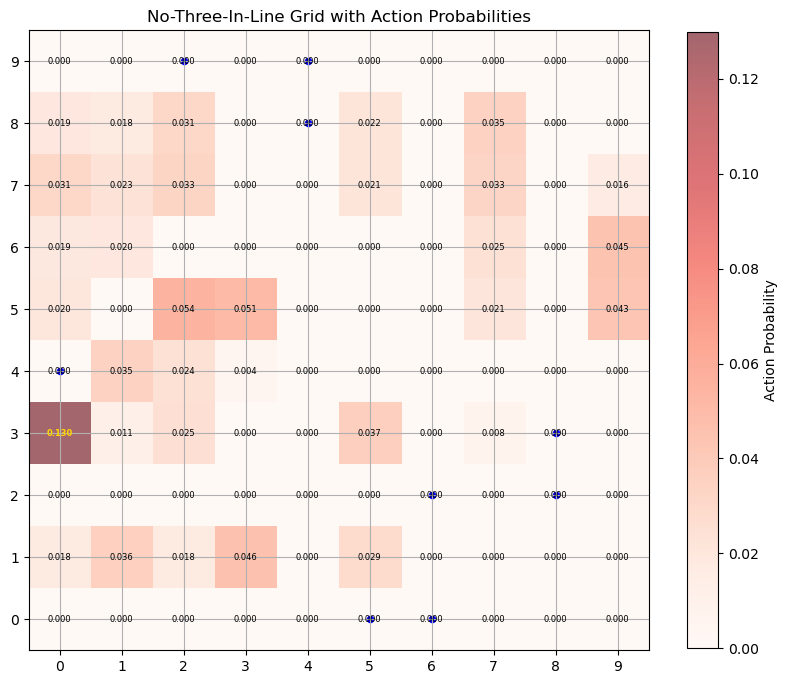

---------------------------
Number of points: 10
[[0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

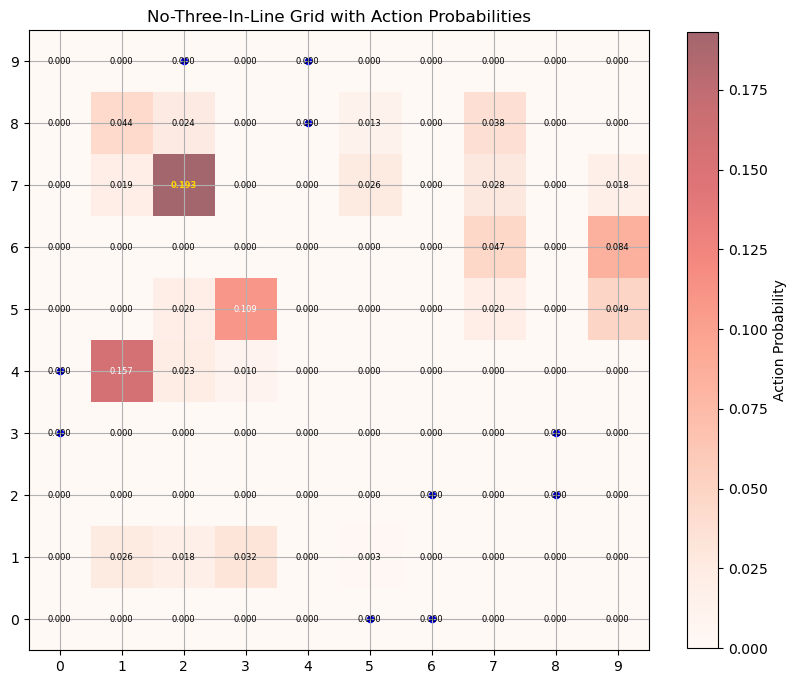

---------------------------
Number of points: 11
[[0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

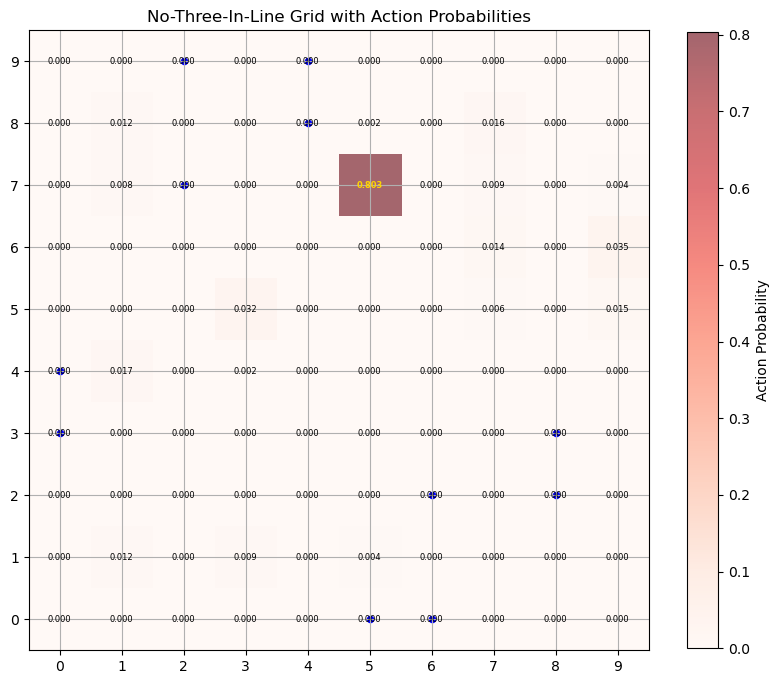

---------------------------
Number of points: 12
[[0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

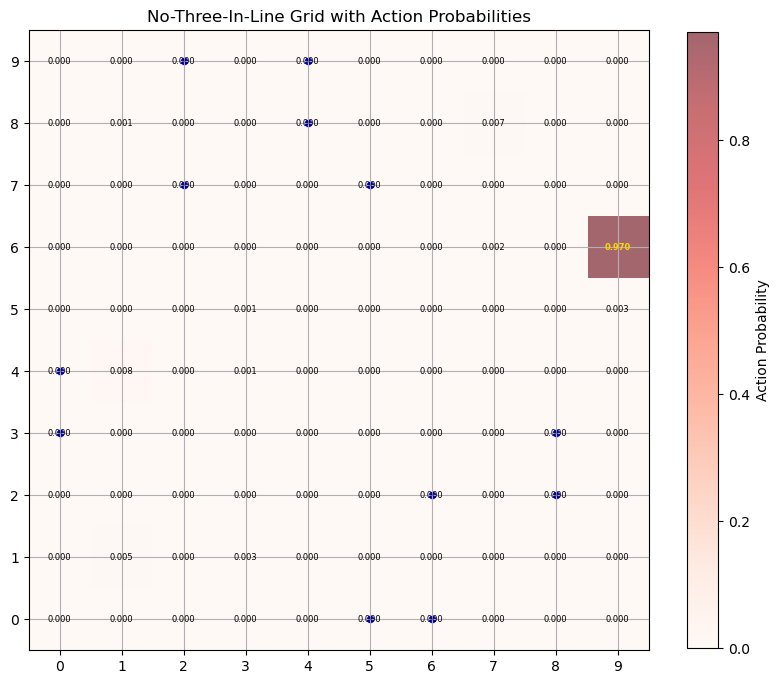

---------------------------
Number of points: 13
[[0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

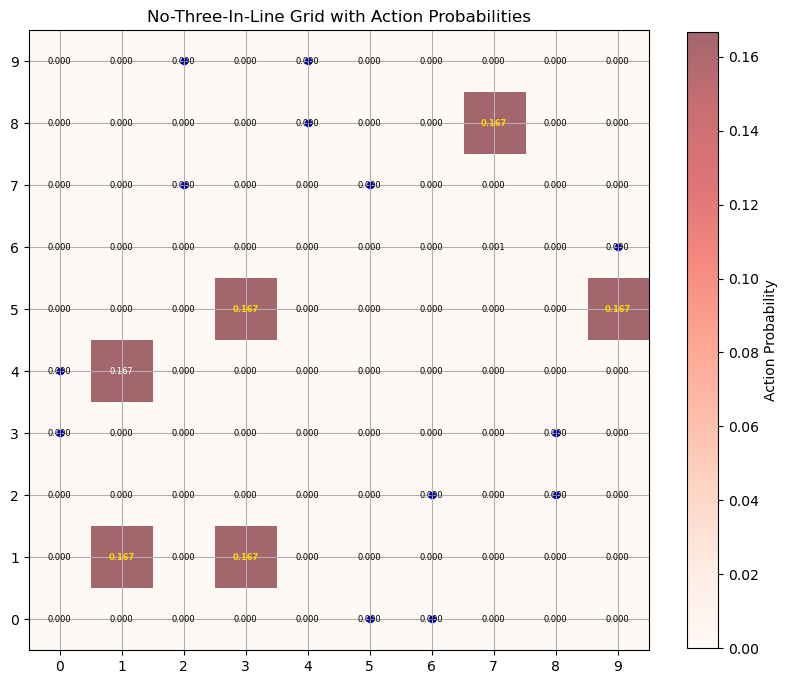

---------------------------
Number of points: 14
[[0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

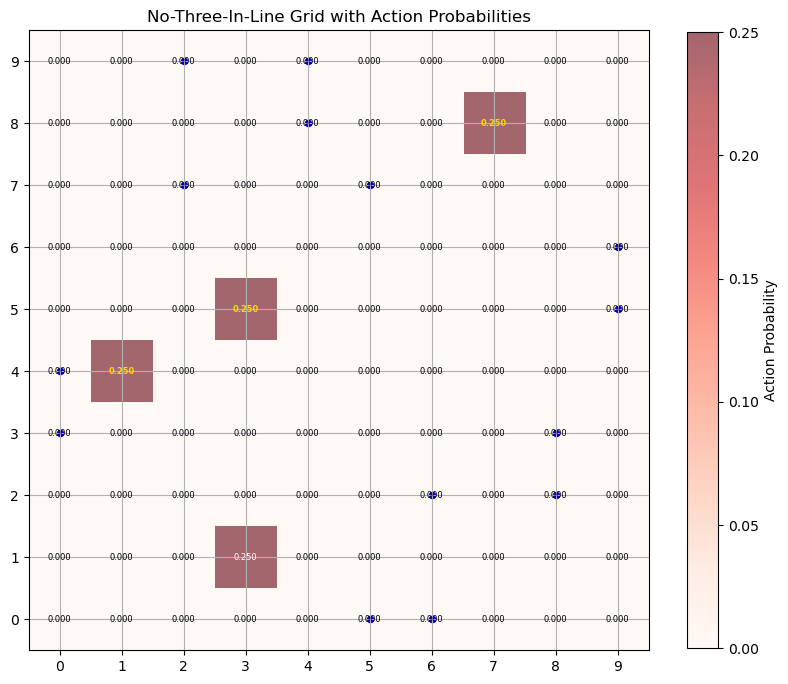

---------------------------
Number of points: 15
[[0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

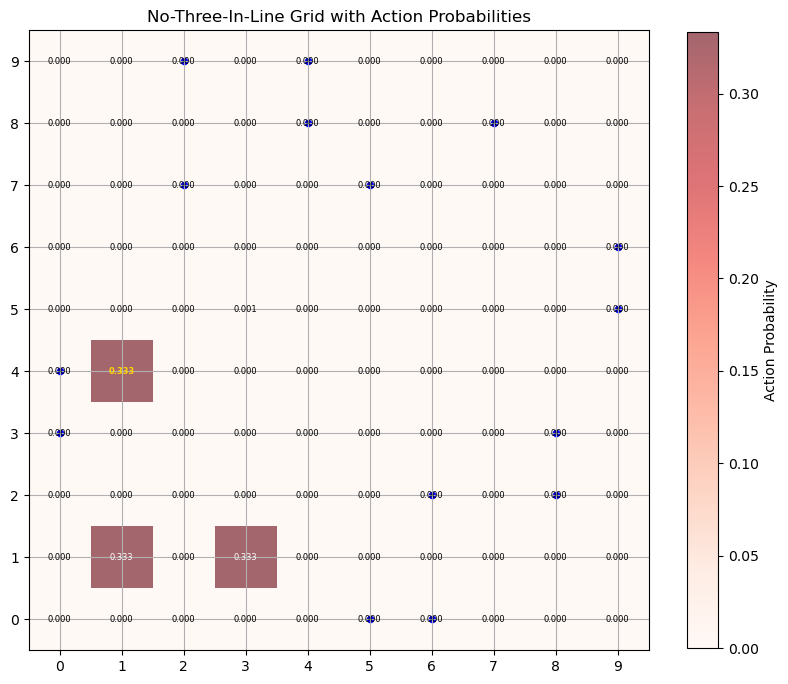

---------------------------
Number of points: 16
[[0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

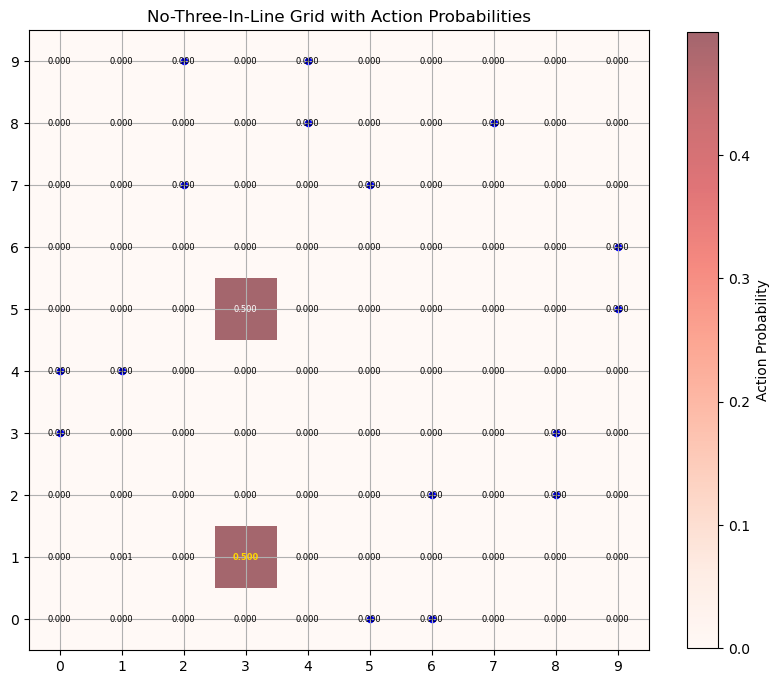

---------------------------
Number of points: 17
[[0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

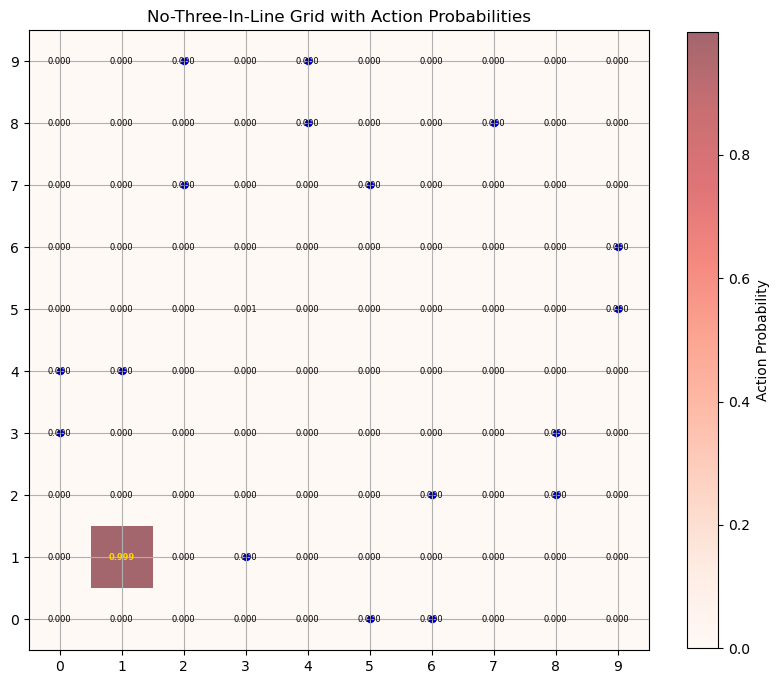

---------------------------
Number of points: 18
[[0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

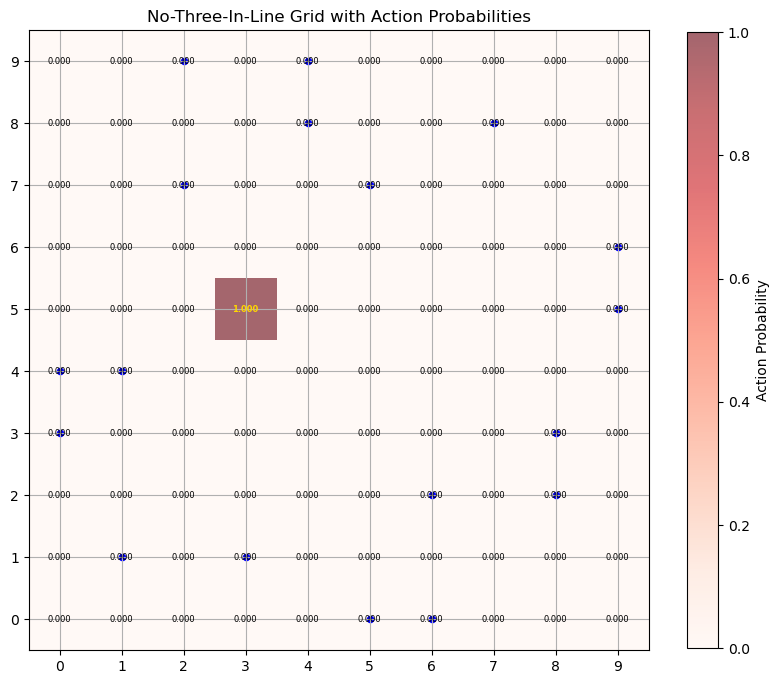

---------------------------
Number of points: 19
[[0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]
*******************************************************************
Trial Terminated with 19 points. Final valid configuration:
[[0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]]


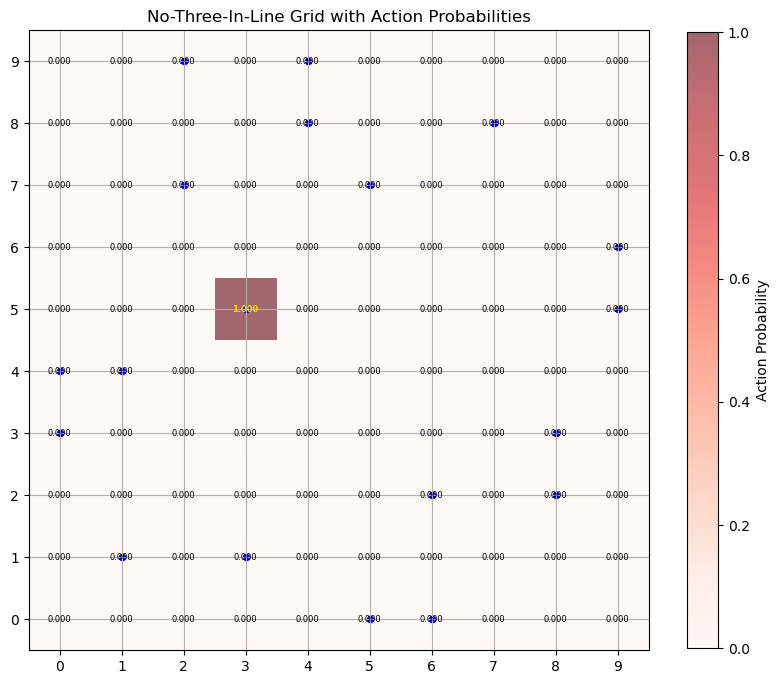

Time: 69.335238 sec


In [5]:
np.random.seed(0)

args = {
        'n': 10,
        'C': 0.2,
        'num_searches': 10_000,
        'num_workers'  : 4,      # >1 ⇒ parallel
        'virtual_loss' : 1.0,     # magnitude to subtract at reservation
        'process_bar' : True,
        'display_state' : True
    }

evaluate(args)

## N = 20

---------------------------
Number of points: 0
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

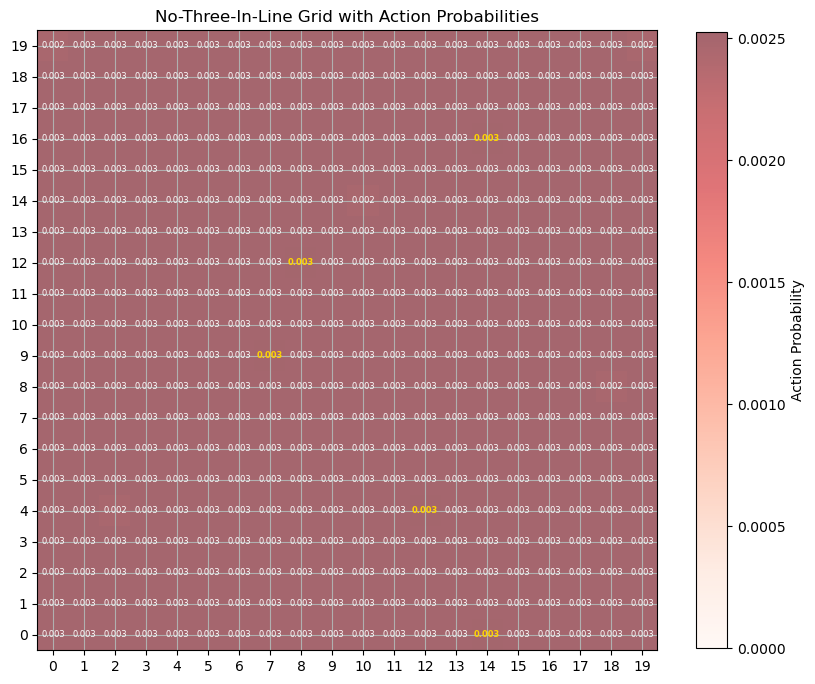

---------------------------
Number of points: 1
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

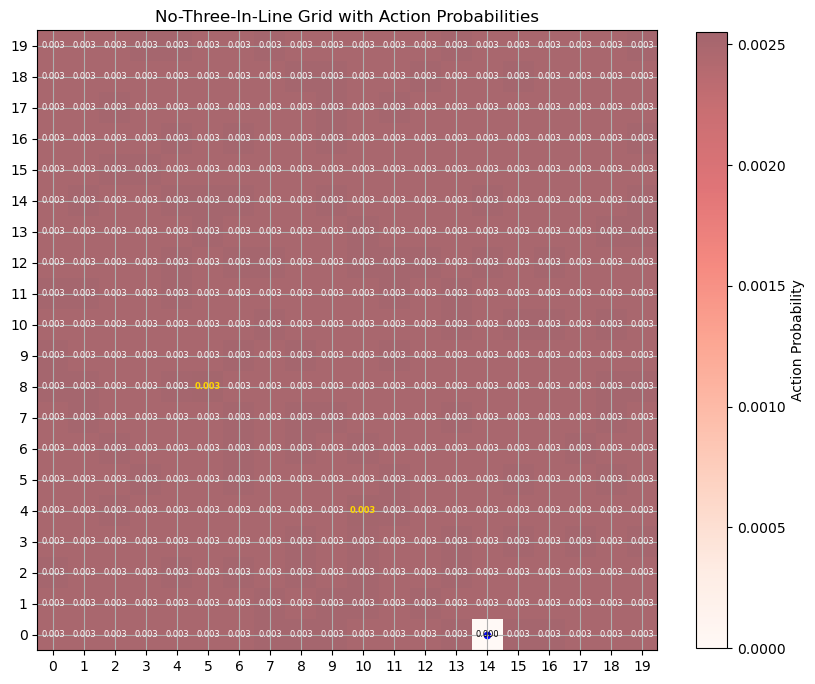

---------------------------
Number of points: 2
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

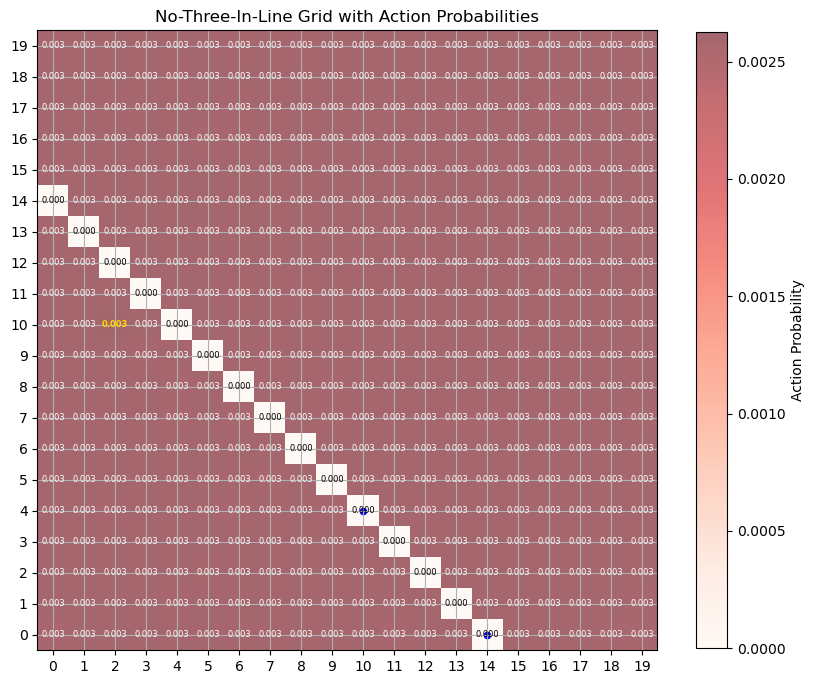

---------------------------
Number of points: 3
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

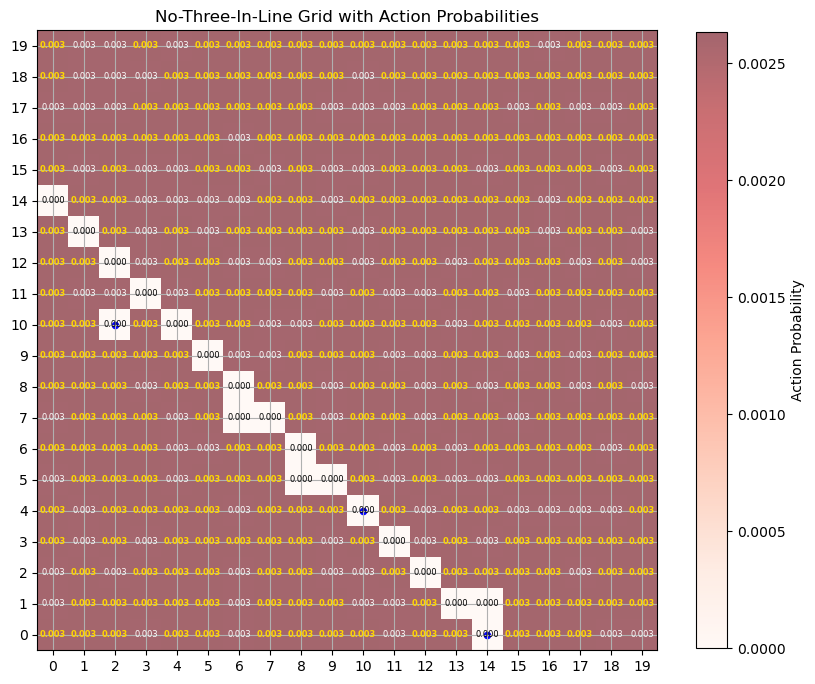

---------------------------
Number of points: 4
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

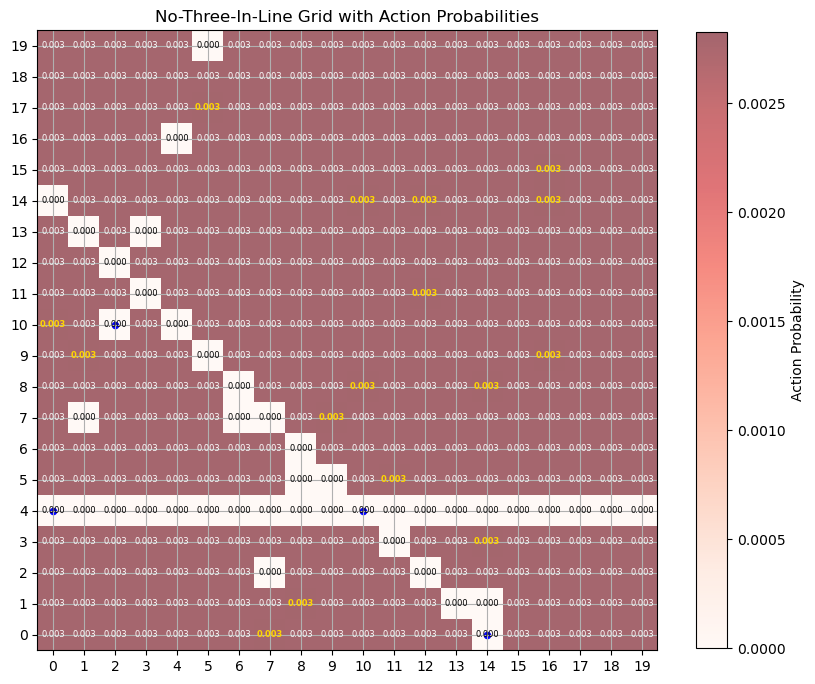

---------------------------
Number of points: 5
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

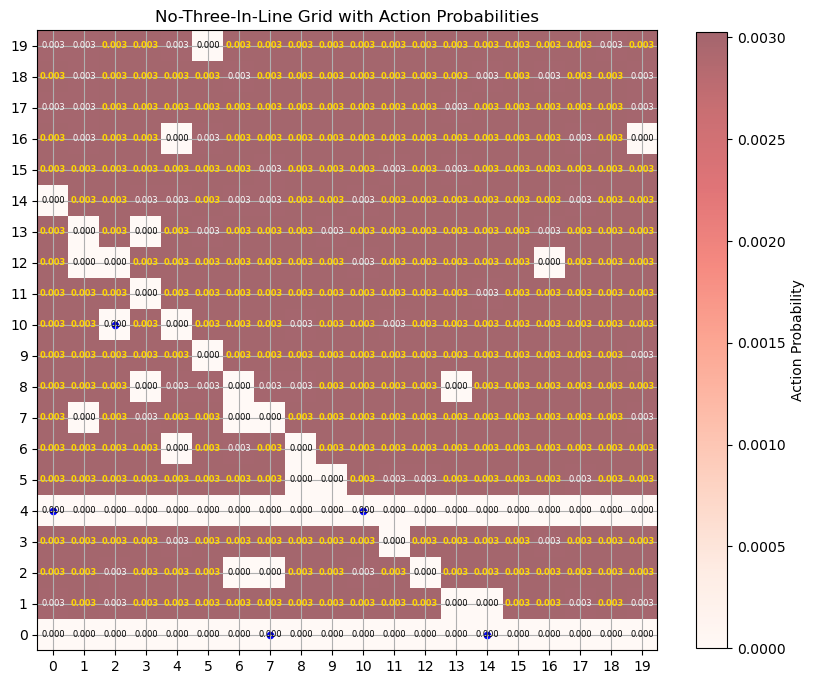

---------------------------
Number of points: 6
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

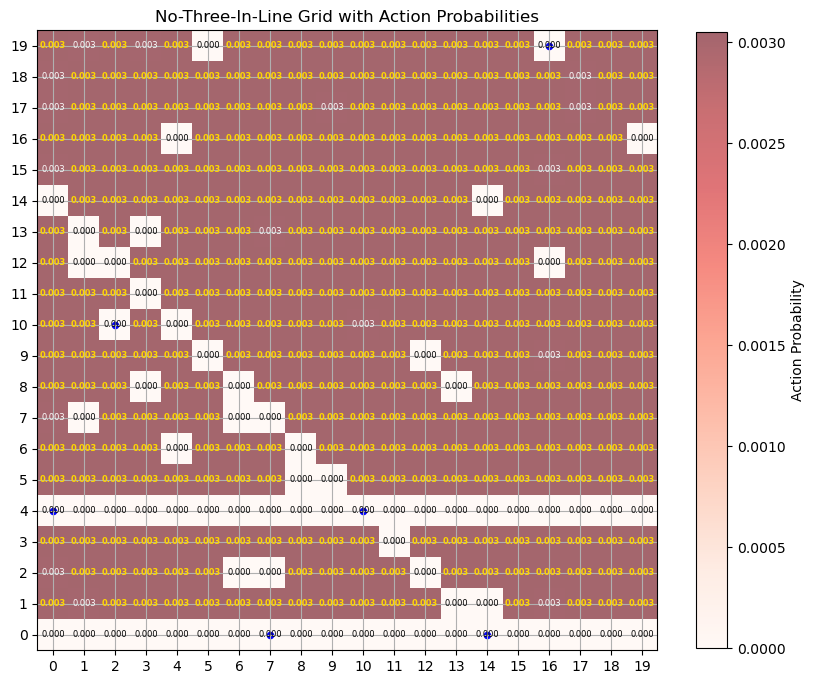

---------------------------
Number of points: 7
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

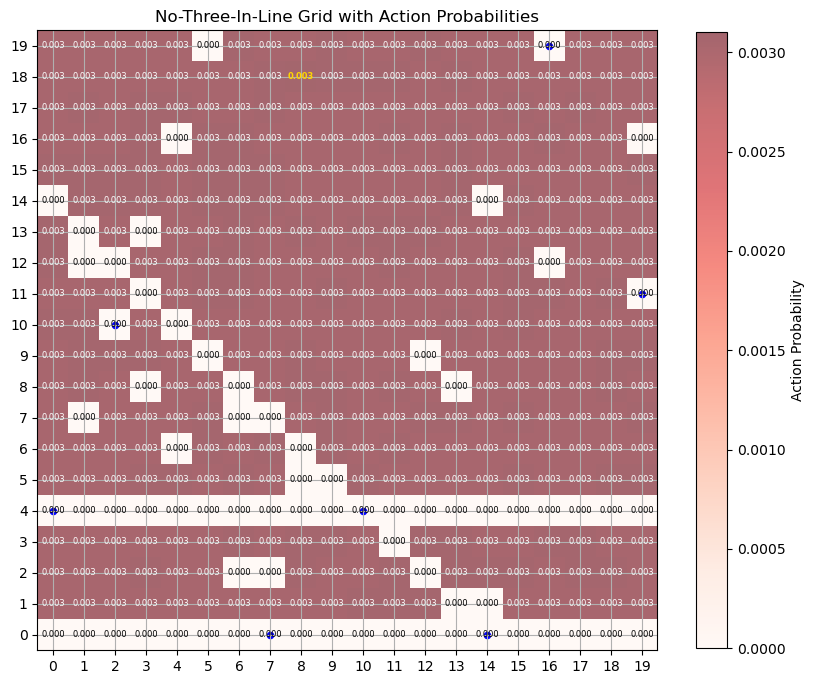

---------------------------
Number of points: 8
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

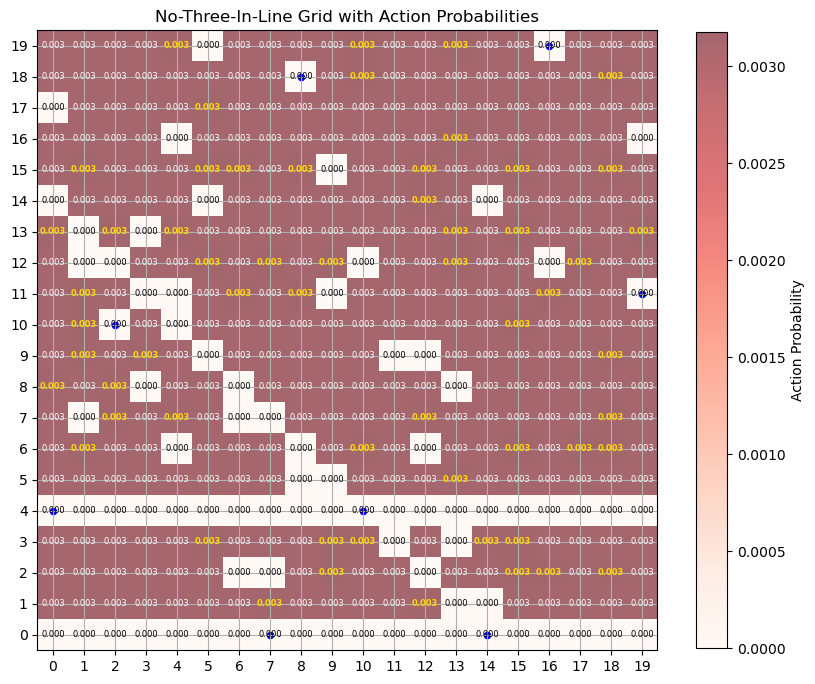

---------------------------
Number of points: 9
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

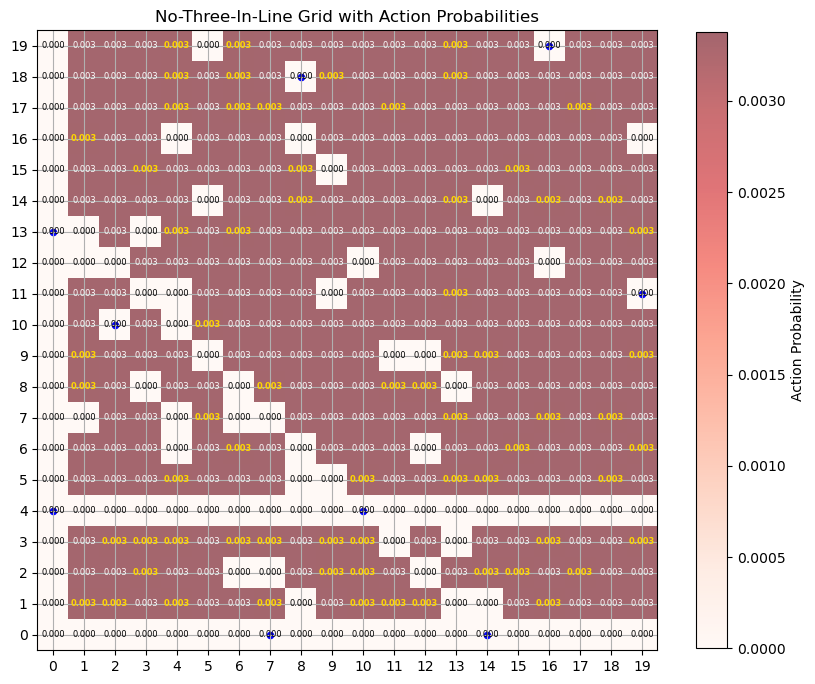

---------------------------
Number of points: 10
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

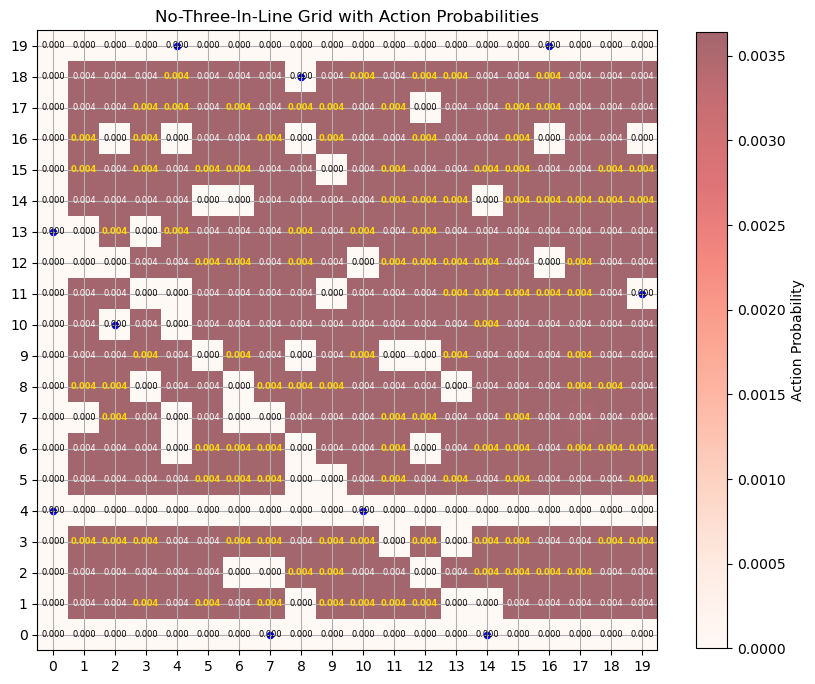

---------------------------
Number of points: 11
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

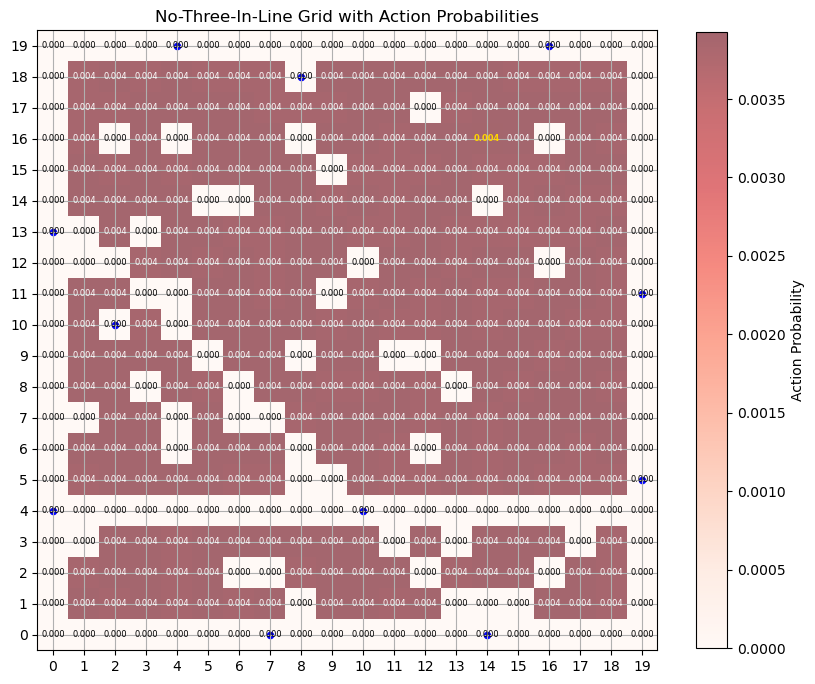

---------------------------
Number of points: 12
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

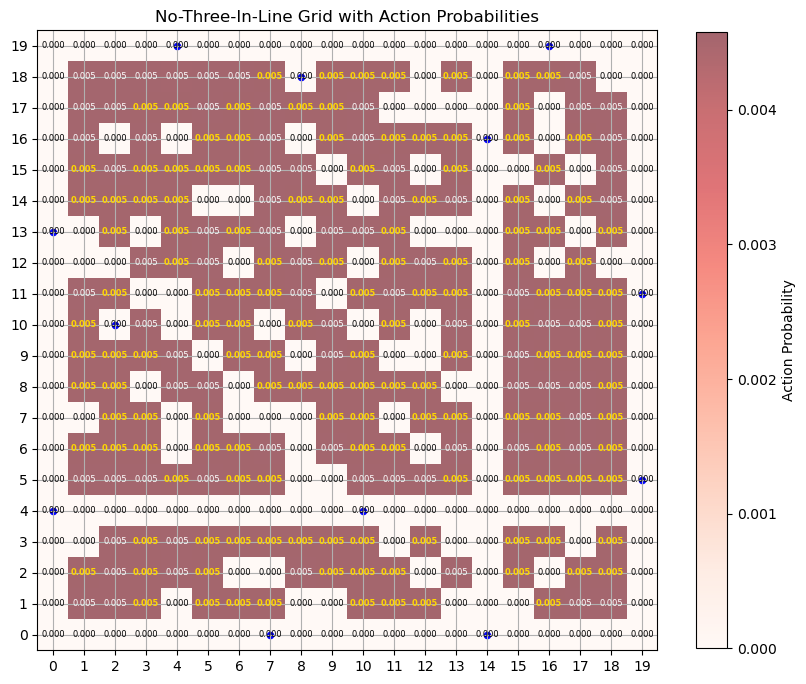

---------------------------
Number of points: 13
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

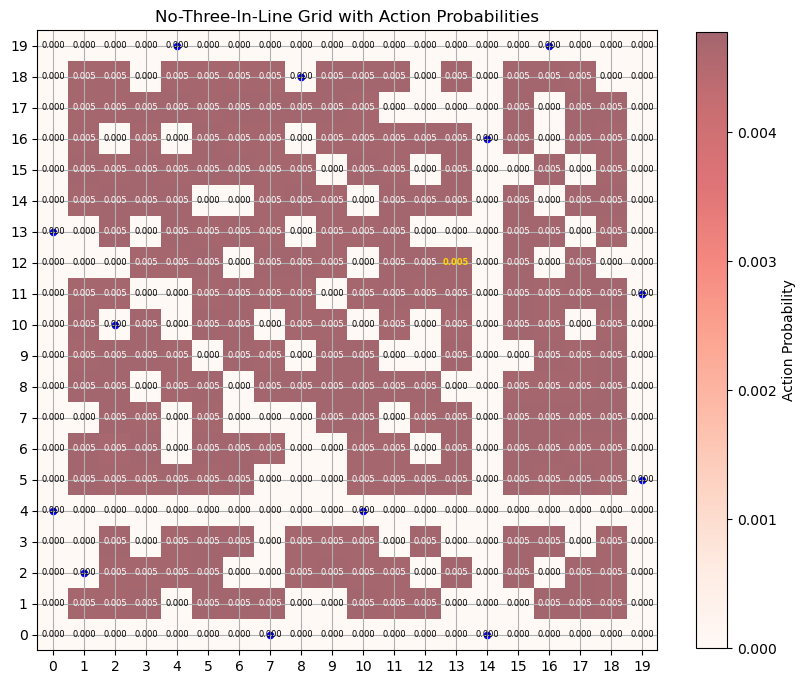

---------------------------
Number of points: 14
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

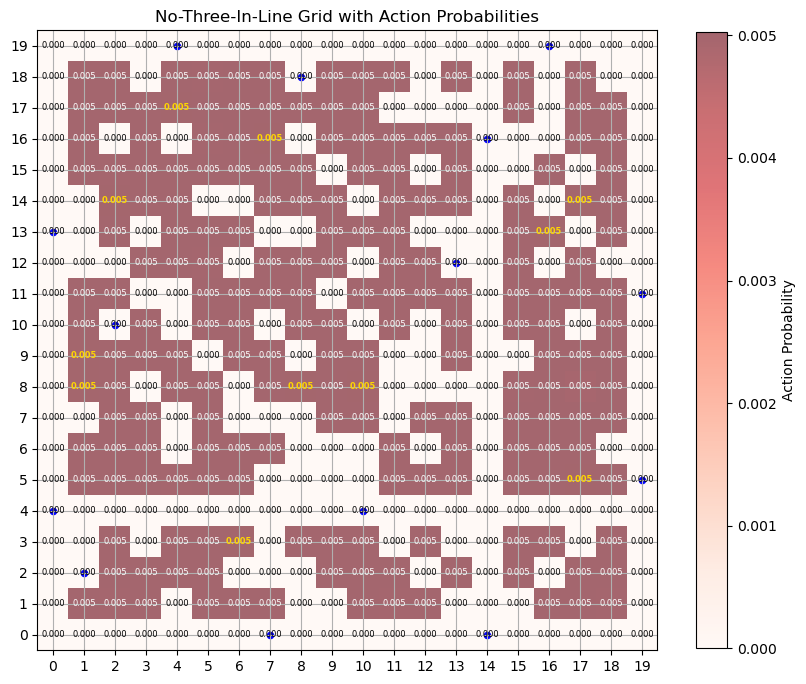

---------------------------
Number of points: 15
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

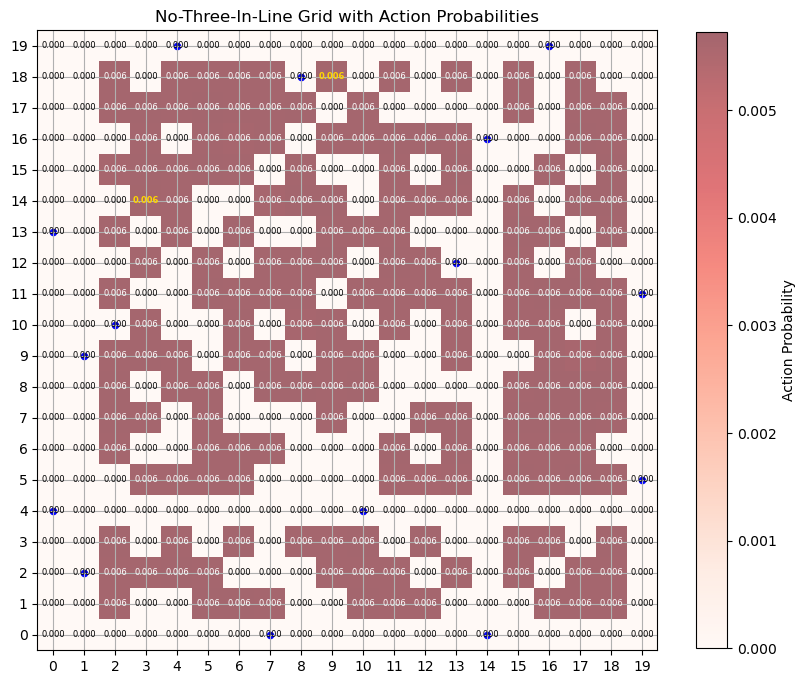

---------------------------
Number of points: 16
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

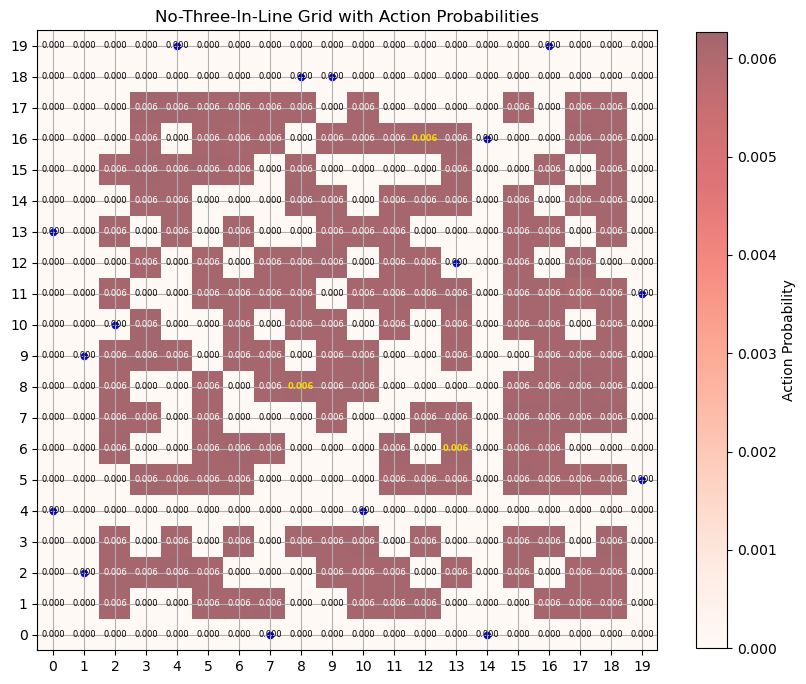

---------------------------
Number of points: 17
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

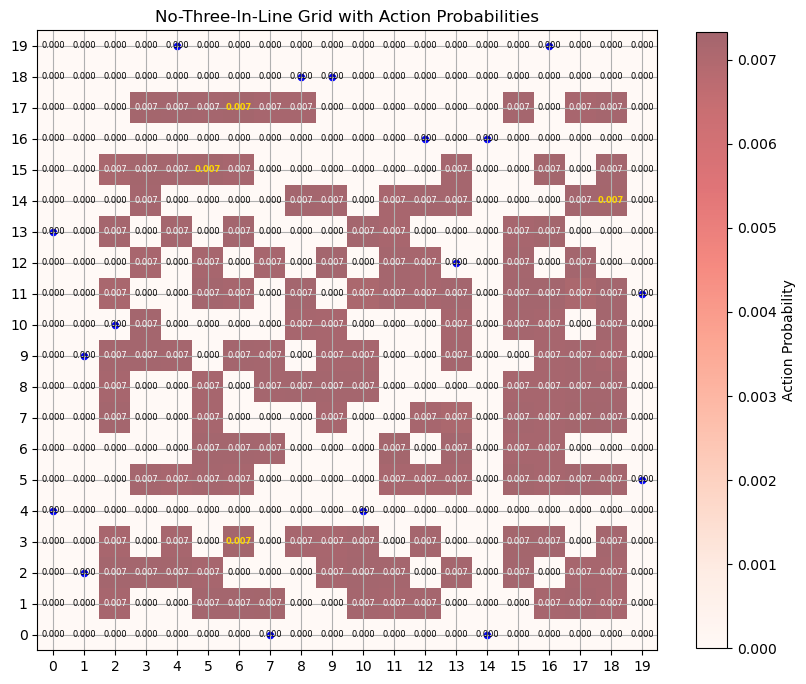

---------------------------
Number of points: 18
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
args = {
        'n': 20,
        'C': 1/np.exp(2),
        'num_searches': 40_000,
        'num_workers'  : 4,      # >1 ⇒ parallel
        'virtual_loss' : 1.0,     # magnitude to subtract at reservation
        'process_bar' : True,
        'display_state' : True
    }

evaluate(args)

In [12]:
2161.154610/60

36.0192435

## Run many simulations

In [301]:
import matplotlib.pyplot as plt
from itertools import combinations

def plot_state_with_collinear(state):
    """
    Plot all points in `state` on a grid and highlight every collinear triple.
    
    Parameters:
    -----------
    state : 2D array-like of 0/1
        A binary grid where 1 indicates a placed point.
    """
    # Determine grid size
    row_count, column_count = state.shape

    # Collect all placed points (row, col)
    points = [(r, c) for r in range(row_count) for c in range(column_count) if state[r, c] == 1]

    # Map array indices to plot coordinates with origin at bottom-left
    plot_coords = [(c, row_count - 1 - r) for r, c in points]

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks(range(column_count))
    ax.set_yticks(range(row_count))
    ax.set_xlim(-0.5, column_count - 0.5)
    ax.set_ylim(-0.5, row_count - 0.5)
    ax.grid(True)

    # Draw the points
    if plot_coords:
        xs, ys = zip(*plot_coords)
        ax.scatter(xs, ys, s=10, c='blue', label='Points')

    # Check every combination of 3 points for collinearity
    for (r1, c1), (r2, c2), (r3, c3) in combinations(points, 3):
        # Use the determinant (area) test for collinearity:
        # (y1 - y2)*(x1 - x3) == (y1 - y3)*(x1 - x2)
        if (r1 - r2) * (c1 - c3) == (r1 - r3) * (c1 - c2):
            # Convert to plot coordinates
            p1 = (c1, row_count - 1 - r1)
            p2 = (c2, row_count - 1 - r2)
            p3 = (c3, row_count - 1 - r3)
            # Choose the two extreme points to draw a line
            line_pts = sorted([p1, p2, p3])
            x_line = [line_pts[0][0], line_pts[-1][0]]
            y_line = [line_pts[0][1], line_pts[-1][1]]
            ax.plot(x_line, y_line, '-', linewidth=.5, label='Collinear Triple' if 'Collinear Triple' not in ax.get_legend_handles_labels()[1] else "")

    ax.legend(loc='upper right')
    ax.set_title("Grid with Points and Collinear Triples")
    plt.show()


In [306]:
def run_multiple_simulations(num_trials, row_count, column_count, pts_upper_bound):
    """
    Run simulate_nb multiple times and keep track of the best result,
    where 'value' is defined as the number of placed points (i.e., sum of state).
    
    Returns:
        best_value: maximum number of points placed
        best_state: corresponding state grid
        all_values: list of all point counts from each trial
    """
    best_value = -1
    best_state = None
    all_values = []

    for i in range(num_trials):
        # Start from an empty state each time
        state = np.zeros((row_count, column_count), dtype=np.uint8)
        _, final_state = simulate_nb(state.copy(), row_count, column_count, pts_upper_bound)
        
        point_count = np.sum(final_state)
        all_values.append(point_count)

        if point_count > best_value:
            best_value = point_count
            best_state = final_state.copy()  # copy to avoid mutation

    return best_value, best_state, all_values


Best value: 150


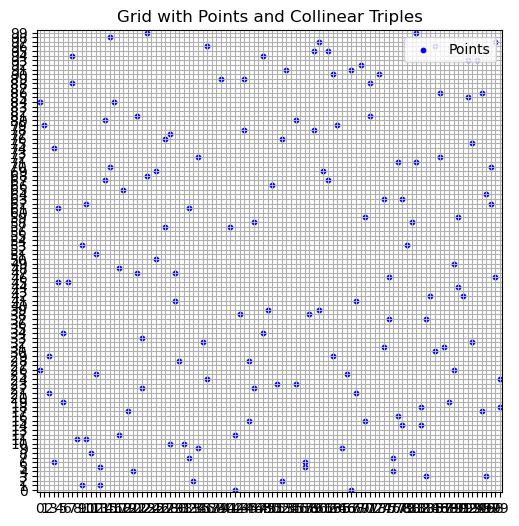

In [309]:
np.random.seed(0)  # Optional: comment this out for real randomness

args1 = {
    'n': 100,
    'C': 0.2,
    'num_searches': 10_000,
    'num_workers'  : 1,      # >1 ⇒ parallel
    'virtual_loss' : 1.0,     # magnitude to subtract at reservation
    'process_bar' : False,
    'display_state' : False
}
n = args1['n']

num_trials = 100
best_val, best_grid, all_vals = run_multiple_simulations(
    num_trials=num_trials,
    row_count=n,
    column_count=n,
    pts_upper_bound=n * 2
)

print("Best value:", best_val)
plot_state_with_collinear(best_grid)

144


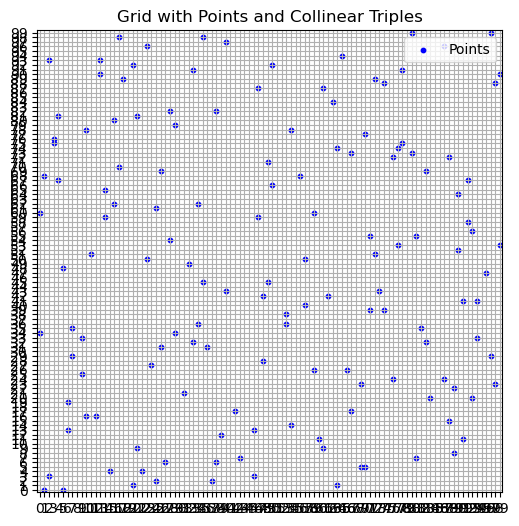

In [ ]:


n3il1 = N3il(grid_size=(n,n), args=args1)
state = n3il1.get_initial_state()
# state = n3il1.get_next_state(state, 0)

value, state = simulate_nb(state, n, n, n*2)

print(np.sum(state))
plot_state_with_collinear(state)